# Comparing Detectors

The purpose of this notebook is to compare the results of tests with specific detectors. We are using PuBe source data for this comparison.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import lmfit as lf
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interp

In [2]:
#Import data

path = 'data/PuBe/overnightdetcal/'

det01 = pd.read_csv(path+'det1.csv')

#All thresholds are defined to be the same.
thresh = (det01.iloc[:,0] + det01.iloc[:,1])/2
del det01

#Ranges will be stored in order.
ranges = []
ranges_u = []
thresh_u = []
for i in range(24):
    try:
        ranges.append(np.asarray(pd.read_csv(path+'det'+str(i)+'.csv').iloc[:,2]))
    except FileNotFoundError:
        ranges.append([])
    try:
        data = pd.read_csv(path+'det'+str(i)+'_upper.csv')
        ranges_u.append(data.iloc[:,2])
        thresh_u.append((data.iloc[:,0] + data.iloc[:,1])/2)
    except FileNotFoundError:
        ranges_u.append([])
        thresh_u.append([])
del data

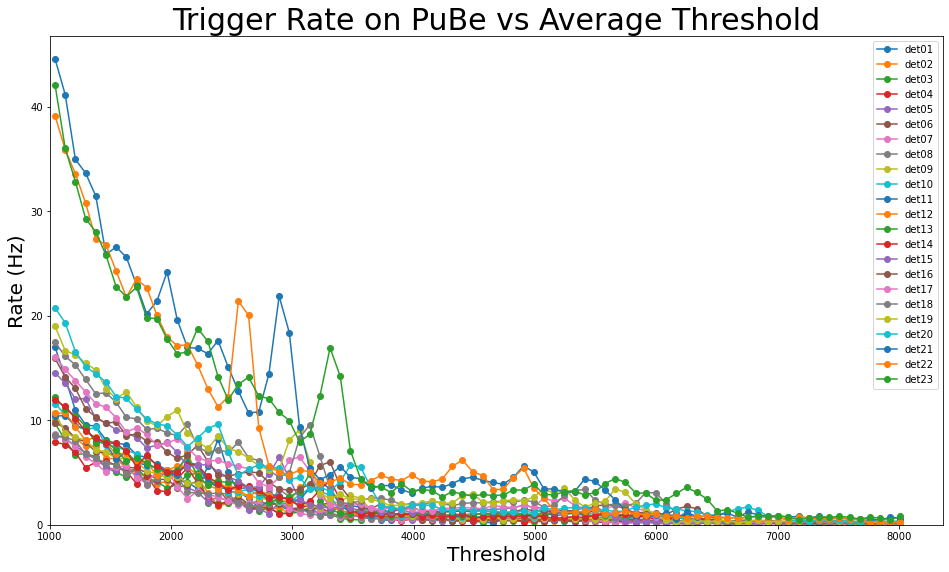

In [3]:
plt.figure(figsize=(16,9))

for i,n in enumerate(ranges):
    if np.asarray(n).size != 0:
        plt.plot(thresh,n,label='det{:02d}'.format(i),marker='o')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.title("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
#lt.yscale('log')
plt.xlim(1000)
plt.ylim(0)

plt.legend()
plt.show()

# Individual Plotting
Pick a number, any number, as long as it's one we have data for.

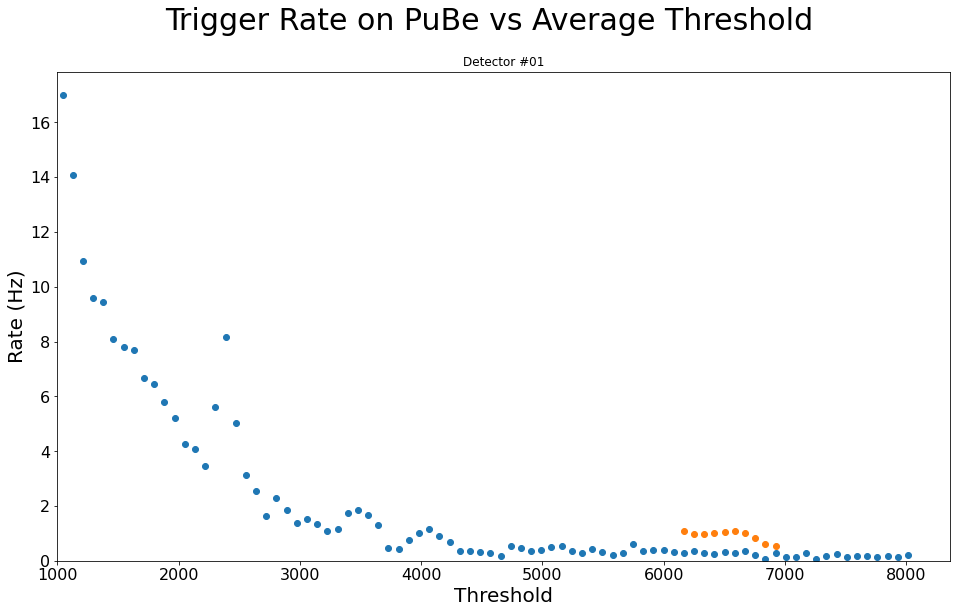

In [4]:
detnum = 1

plt.figure(figsize=(16,9))

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

plt.show()

# Calibration

Now here's the long section, where we calibrate every detector one by one.

## Finding the calibration lines

In [5]:
#set up some empty arrays to fill later
#each contains an empty array to start counting from 1 instead of 0.
bins = [[]]
energies = [[]]

def gaussian(x,a,m,s):
    return a*np.exp(-(x-m)**2/(2*s**2))

gauss_mod = lf.Model(gaussian)
gauss_params = gauss_mod.make_params()
gauss_params.add('s',value=1,min=0)

fine = np.arange(min(thresh),max(thresh))

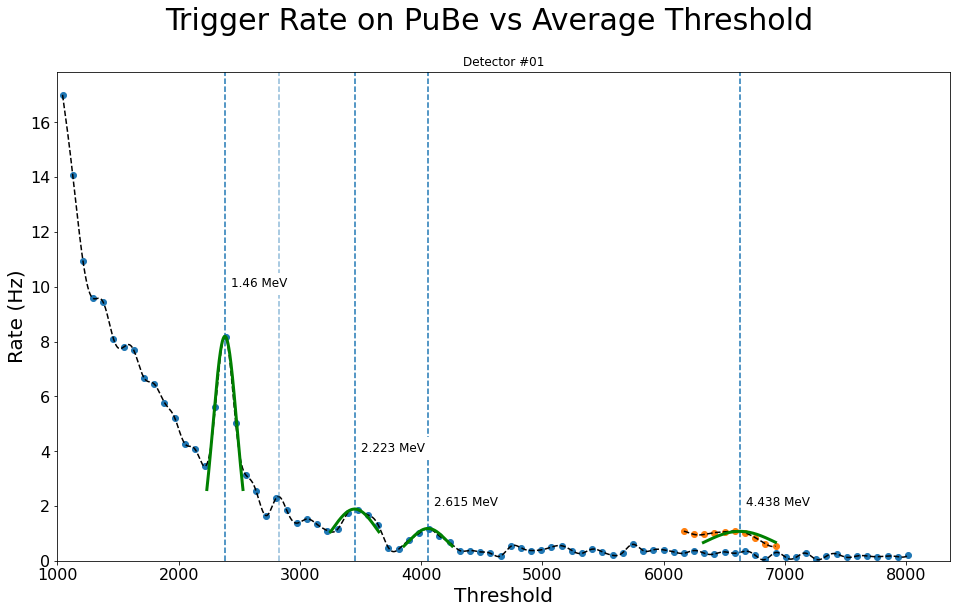

In [6]:
detnum = 1

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2394
b = 2800
c = 3500
d = 4060
e = 6675

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,10,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--',alpha=0.5)

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,4,"2.223 MeV",fontsize=12,backgroundcolor='white')
plt.axvline(d,linestyle='--')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 200],gauss_params,x=fine[abs(fine - c) < 200])
plt.plot(fine[abs(fine - c) < 200],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.text(d+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
plt.axvline(e,linestyle='--')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 200],gauss_params,x=fine[abs(fine - d) < 200])
plt.plot(fine[abs(fine - d) < 200],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.text(e+50,2,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 300],gauss_params,x=fine_u[abs(fine_u - e) < 300])
plt.plot(fine_u[abs(fine_u - e) < 300],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins01 = [a,c,d,e]
energies01 = [1460,2223,2600,4438]
uncertainties01 = [a_s,c_s,d_s,e_s]

plt.show()

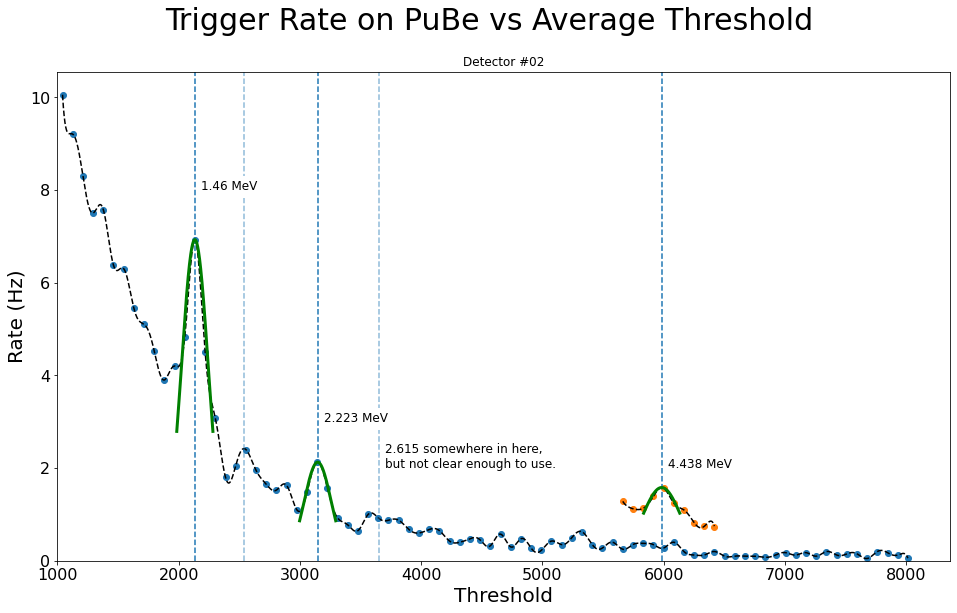

In [7]:
detnum = 2

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2135
b = 2552
c = 3150
d = 3700
e = 6000

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,8,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--',alpha=0.5)

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)
plt.text(d+50,2,"2.615 somewhere in here,\nbut not clear enough to use.",fontsize=12,backgroundcolor='white')

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,2,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins02 = [a,c,e]
energies02 = [1460,2223,4438]
uncertainties02 = [a_s,c_s,e_s]

plt.show()

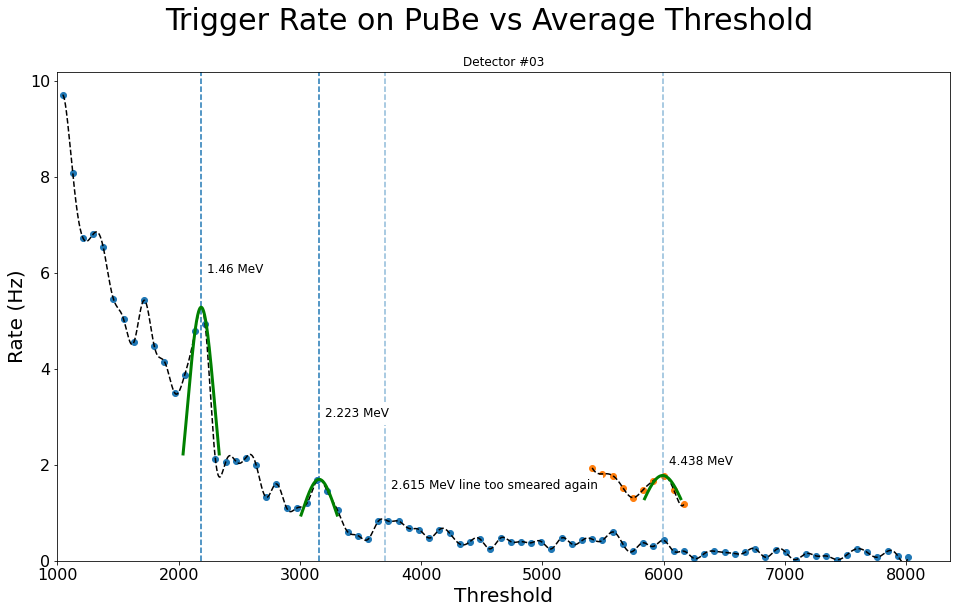

In [8]:
detnum = 3

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2185
b = 3180
c = 3750
d = 6000

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - d) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,3,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--',alpha=0.5)
plt.text(c+50,1.5,"2.615 MeV line too smeared again",fontsize=12,backgroundcolor='white')

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)
plt.text(d+50,2,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==d],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - d) < 150],gauss_params,x=fine_u[abs(fine_u - d) < 150])
plt.plot(fine_u[abs(fine_u - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Save Info
bins03 = [a,b,d]
energies03 = [1460,2223,4438]
uncertainties03 = [a_s,b_s,c_s]

plt.show()

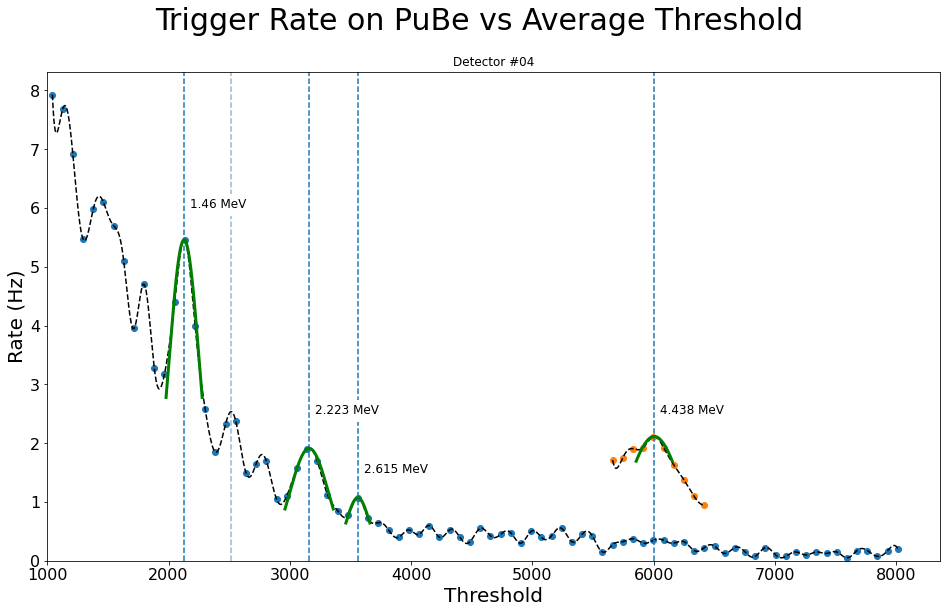

In [9]:
detnum = 4

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2139
b = 2534
c = 3150
d = 3562
e = 6000

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--',alpha=0.5)

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2.5,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 200],gauss_params,x=fine[abs(fine - c) < 200])
plt.plot(fine[abs(fine - c) < 200],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,1.5,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 100],gauss_params,x=fine[abs(fine - d) < 100])
plt.plot(fine[abs(fine - d) < 100],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,2.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins04 = [a,c,d,e]
energies04 = [1460,2223,2600,4438]
uncertainties04 = [a_s,c_s,d_s,e_s]

plt.show()

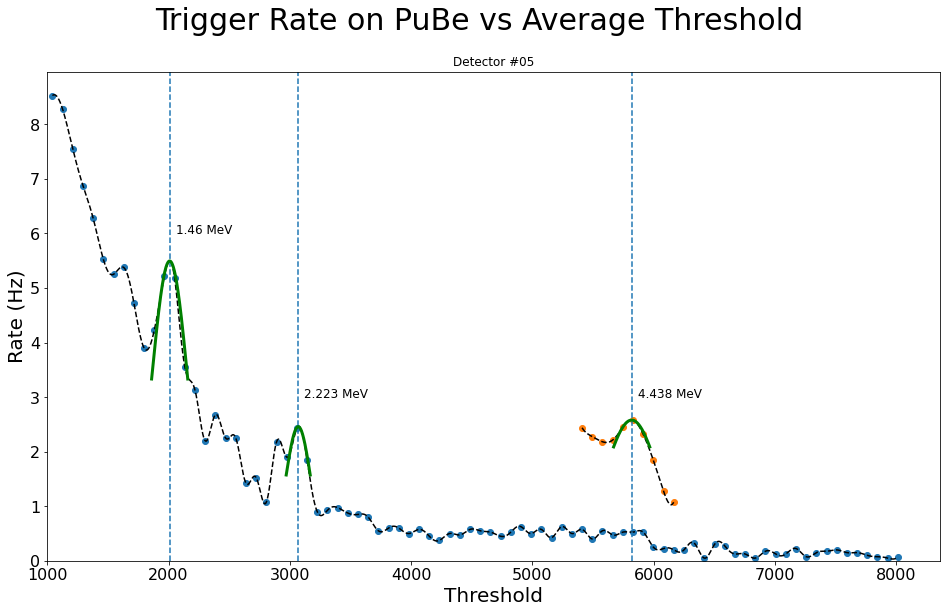

In [10]:
detnum = 5

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2000
b = 3020
c = 5800

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - c) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,3,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 100],gauss_params,x=fine[abs(fine - b) < 100])
plt.plot(fine[abs(fine - b) < 100],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==c],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - c) < 150],gauss_params,x=fine_u[abs(fine_u - c) < 150])
plt.plot(fine_u[abs(fine_u - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Save Info
bins05 = [a,b,c]
energies05 = [1460,2223,4438]
uncertainties05 = [a_s,b_s,c_s]

plt.show()

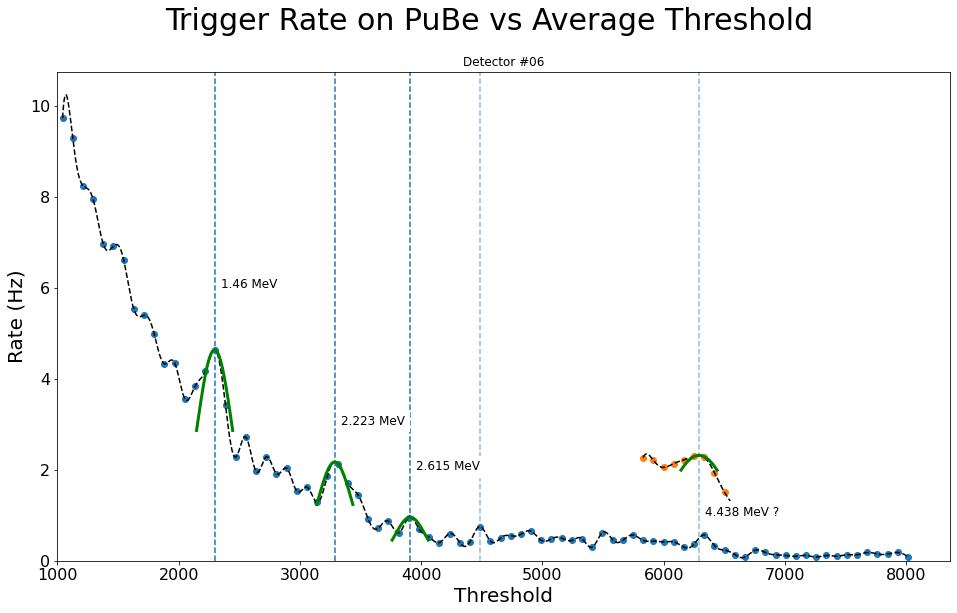

In [11]:
detnum = 6

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2300
b = 3320
c = 3900
d = 4485
e = 6340

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,3,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)

#Point E
plt.axvline(e,linestyle='--',alpha=0.5)
plt.text(e+50,1,"4.438 MeV ?",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins06 = [a,b,c,e]
energies06 = [1460,2223,2600,4438]
uncertainties06 = [a_s,b_s,c_s,e_s]

plt.show()

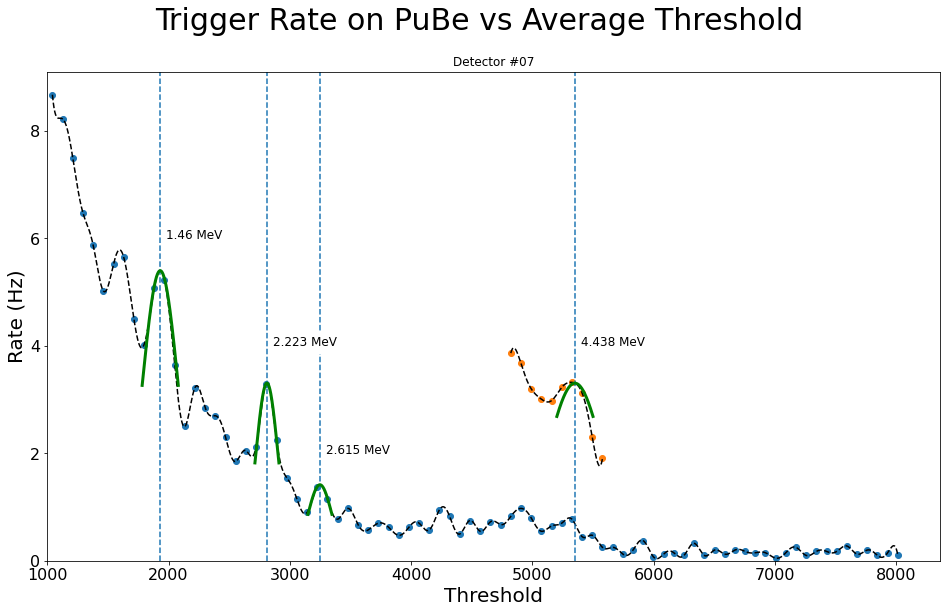

In [12]:
detnum = 7

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

b = 1925
c = 2800
d = 3250
e = 5400

b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,4,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Poitn D
plt.axvline(d,linestyle='--')
plt.text(d+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 100],gauss_params,x=fine[abs(fine - d) < 100])
plt.plot(fine[abs(fine - d) < 100],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,4,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins07 = [b,c,d,e]
energies07 = [1460,2223,2600,4438]
uncertainties07 = [a_s,b_s,c_s,d_s]

plt.show()

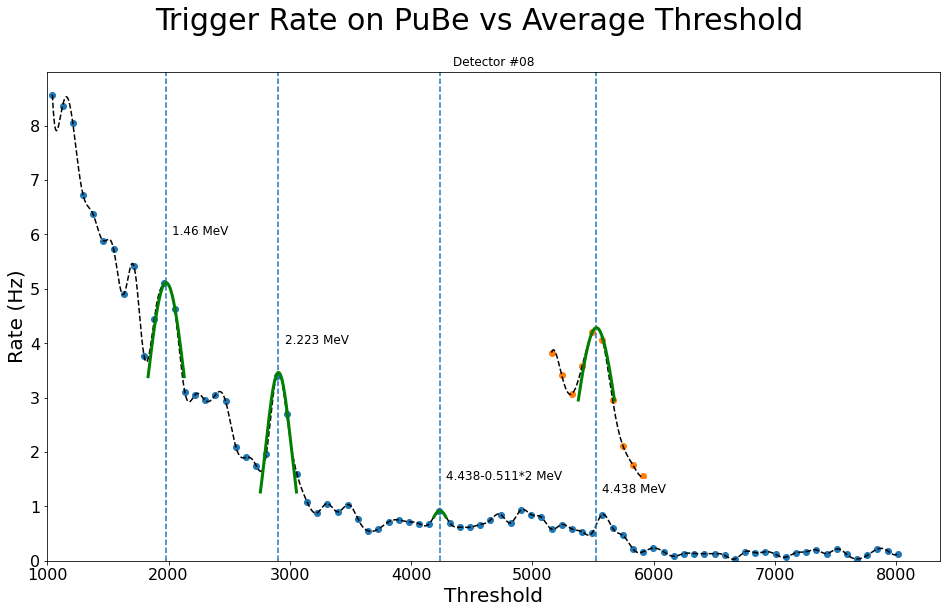

In [13]:
detnum = 8

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2000
b = 2900
c = 4238
d = 5568

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - d) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,4,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,1.5,"4.438-0.511*2 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 50],gauss_params,x=fine[abs(fine - c) < 50])
plt.plot(fine[abs(fine - c) < 50],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,1.25,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==d],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - d) < 150],gauss_params,x=fine_u[abs(fine_u - d) < 150])
plt.plot(fine_u[abs(fine_u - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Save Info
bins08 = [a,b,c,d]
energies08 = [1460,2223,4438-2*511,4438]
uncertainties08 = [a_s,b_s,c_s,d_s]

plt.show()

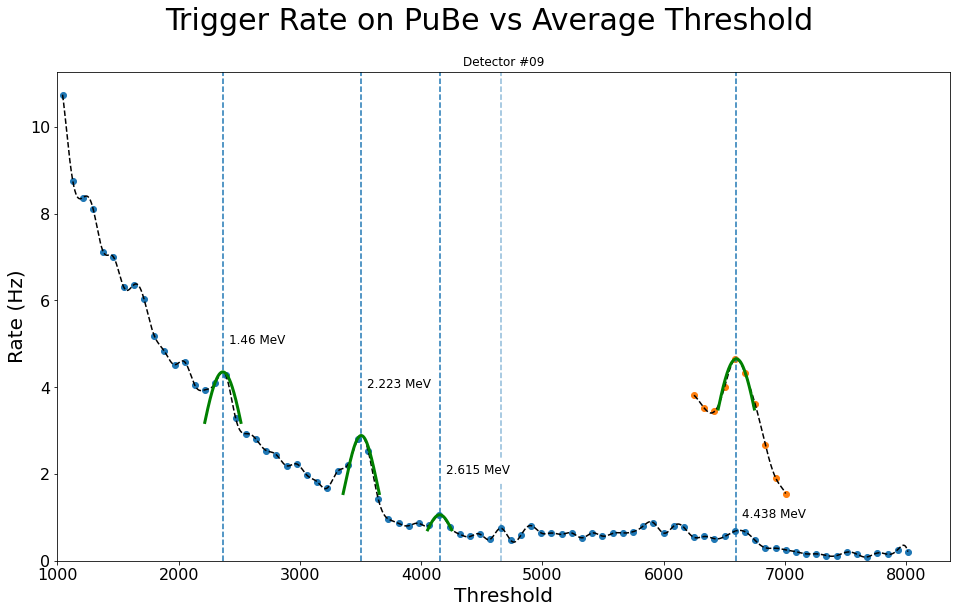

In [14]:
detnum = 9

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2400
b = 3500
c = 4150
d = 4655
e = 6630

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,5,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,4,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,1,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins09 = [a,b,c,e]
energies09 = [1460,2223,2600,4438]
uncertainties09 = [a_s,b_s,c_s,e_s]

plt.show()

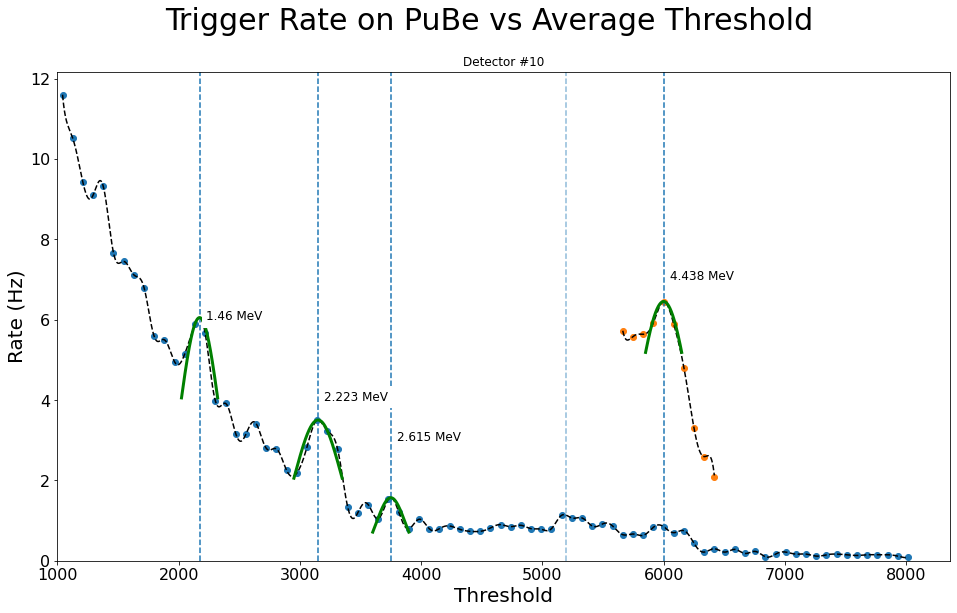

In [15]:
detnum = 10

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2170
b = 3170
c = 3730
d = 5240
e = 5950

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,4,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 200],gauss_params,x=fine[abs(fine - b) < 200])
plt.plot(fine[abs(fine - b) < 200],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,7,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins10 = [a,b,c,e]
energies10 = [1460,2223,2600,4438]
uncertainties10 = [a_s,b_s,c_s,e_s]

plt.show()

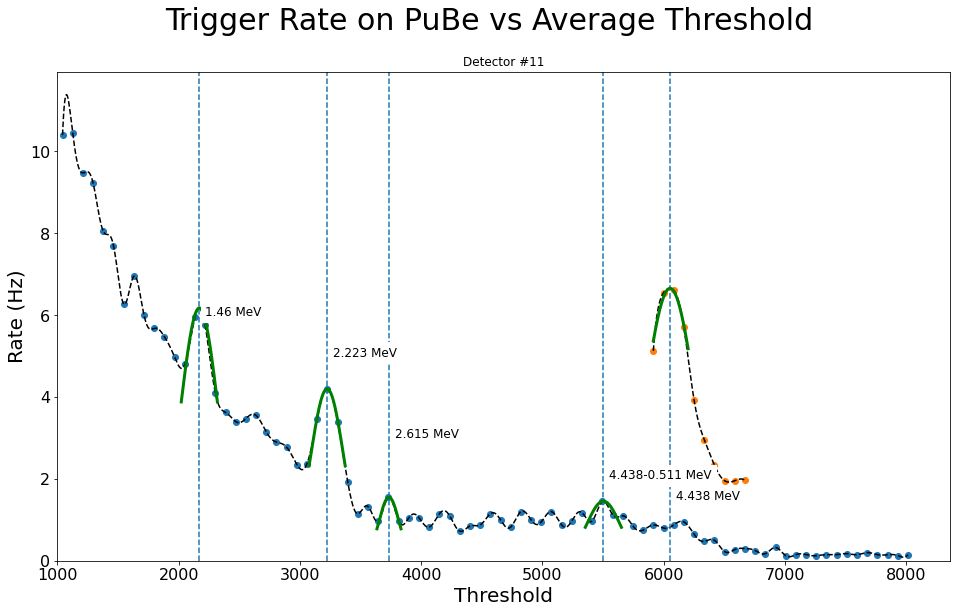

In [16]:
detnum = 11

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2170
b = 3225
c = 3730
d = 5500
e = 6100

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,5,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,2,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,1.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins11 = [a,b,c,d,e]
energies11 = [1460,2223,2600,4438-511,4438]
uncertainties11 = [a_s,b_s,c_s,d_s,e_s]

plt.show()

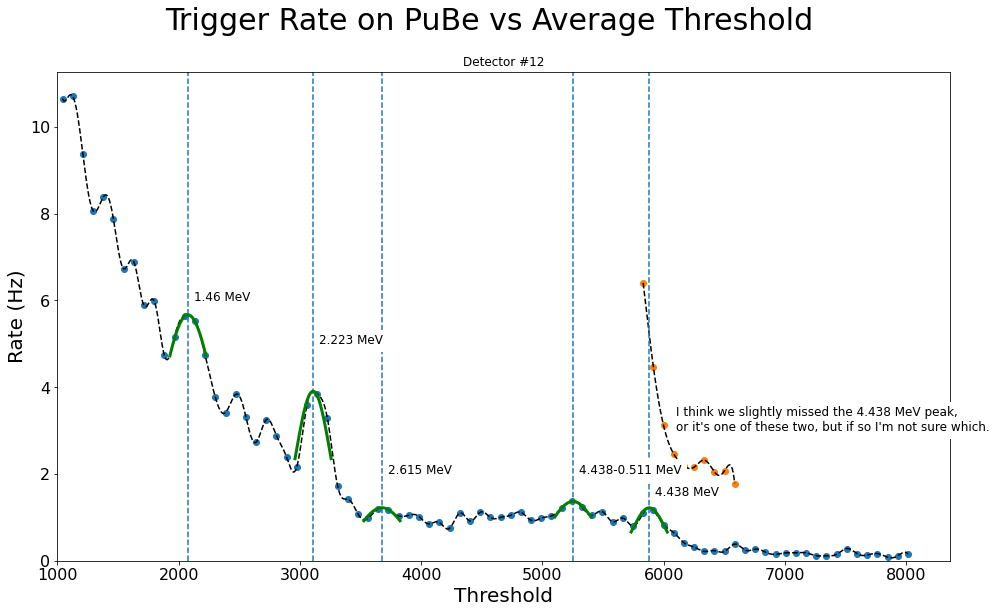

In [17]:
detnum = 12

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2095
b = 3149
c = 3705
d = 5245
e = 5900

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,5,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,2,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,1.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
plt.text(6100,3,"I think we slightly missed the 4.438 MeV peak,\nor it's one of these two, but if so I'm not sure which.",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine[abs(fine - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins12 = [a,b,c,d,e]
energies12 = [1460,2223,2600,4438-511,4438]
uncertainties12 = [a_s,b_s,c_s,d_s,e_s]

plt.show()

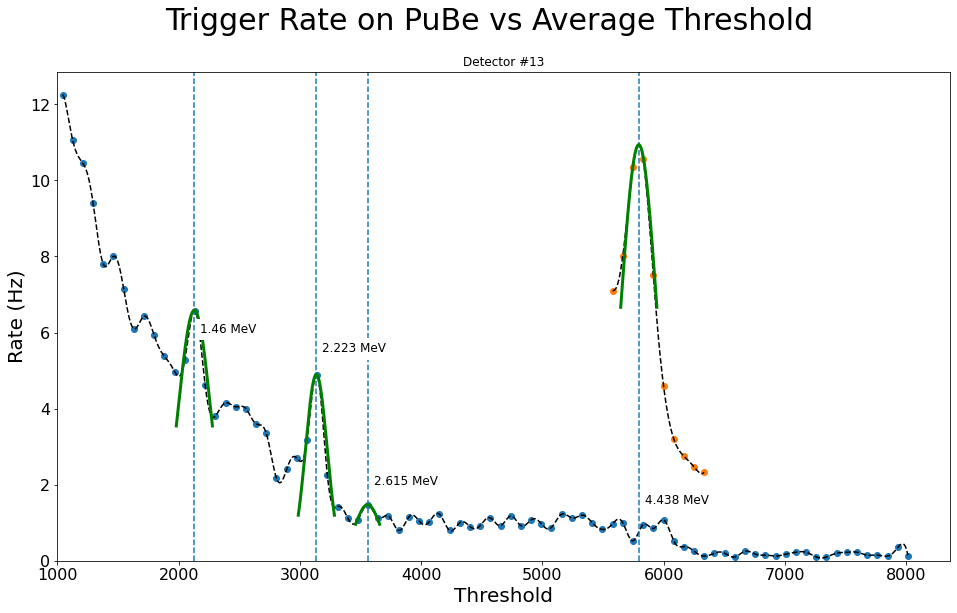

In [18]:
detnum = 13

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2135
b = 3140
c = 3560
d = 5800

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - d) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,5.5,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,1.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==d],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - d) < 150],gauss_params,x=fine_u[abs(fine_u - d) < 150])
plt.plot(fine_u[abs(fine_u - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Save Info
bins13 = [a,b,c,d]
energies13 = [1460,2223,2600,4438]
uncertainties13 = [a_s,b_s,c_s,d_s]

plt.show()

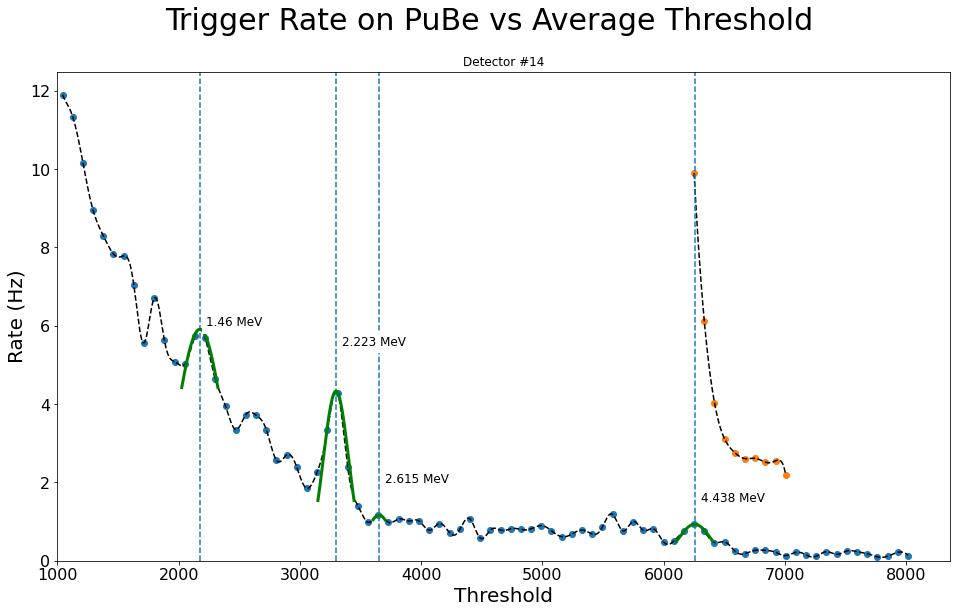

In [19]:
detnum = 14

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2180
b = 3325
c = 3650
d = 6250

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,6,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,5.5,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,2,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 50],gauss_params,x=fine[abs(fine - c) < 50])
plt.plot(fine[abs(fine - c) < 50],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,1.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Save Info
bins14 = [a,b,c,d]
energies14 = [1460,2223,2600,4438]
uncertainties14 = [a_s,b_s,c_s,d_s]

plt.show()

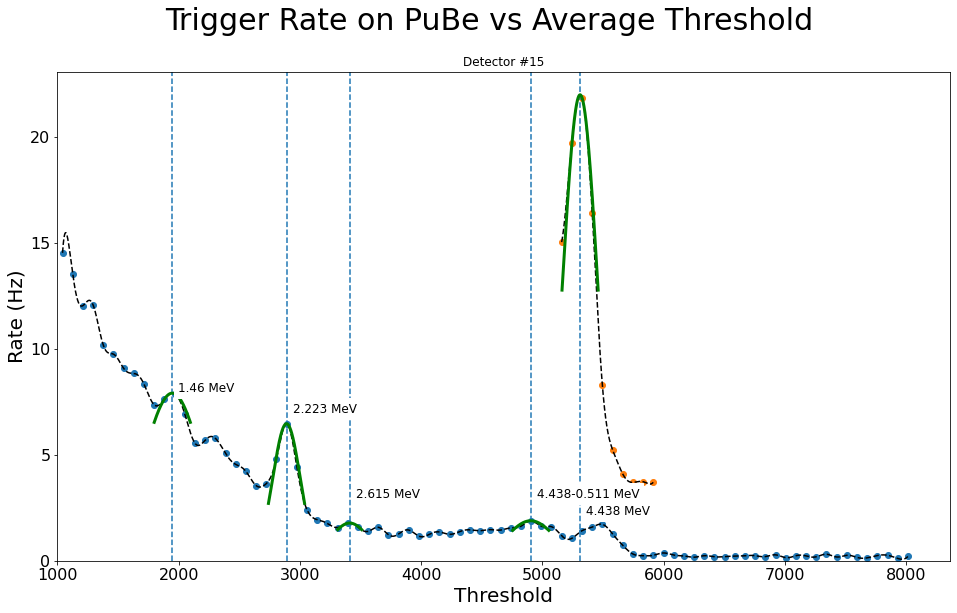

In [20]:
detnum = 15

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 1974
b = 2897
c = 3402
d = 4905
e = 5300

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,8,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,7,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,3,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,2.2,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins15 = [a,b,c,d,e]
energies15 = [1460,2223,2600,4438-511,4438]
uncertainties15 = [a_s,b_s,c_s,d_s,e_s]

plt.show()

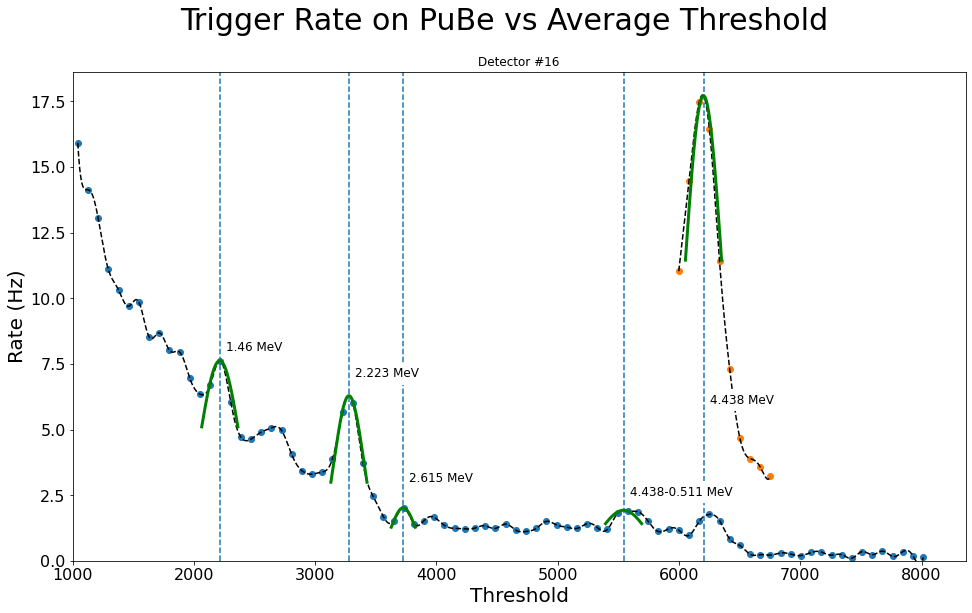

In [21]:
detnum = 16

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2212
b = 3290
c = 3725
d = 5592
e = 6251

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,8,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,7,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 100],gauss_params,x=fine[abs(fine - c) < 100])
plt.plot(fine[abs(fine - c) < 100],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,2.5,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,6,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins16 = [a,b,c,d,e]
energies16 = [1460,2223,2600,4438-511,4438]
uncertainties16 = [a_s,b_s,c_s,d_s,e_s]

plt.show()

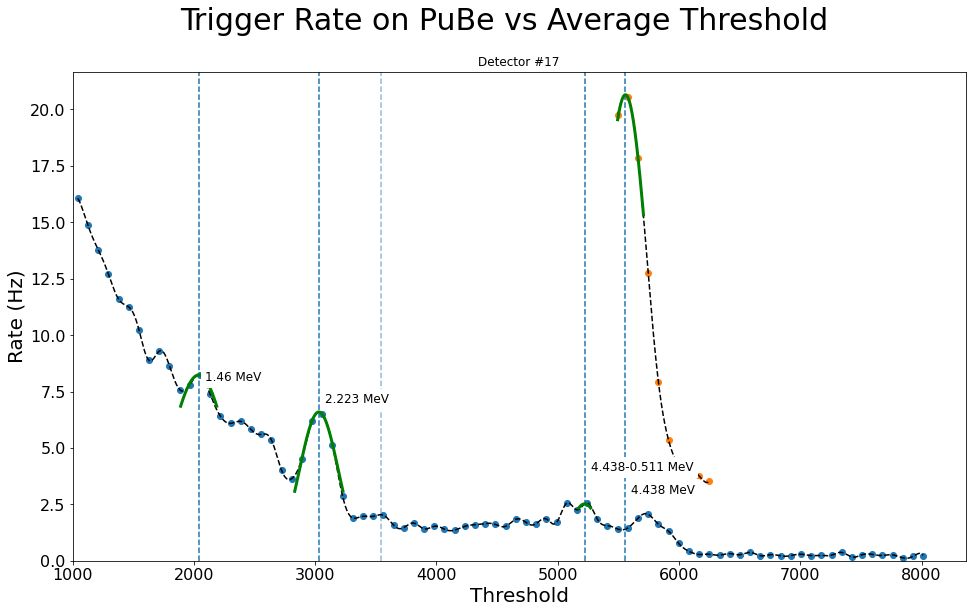

In [22]:
detnum = 17

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2055
b = 3067
c = 3563
d = 5173
e = 5600

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,8,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,7,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 200],gauss_params,x=fine[abs(fine - b) < 200])
plt.plot(fine[abs(fine - b) < 200],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--',alpha=0.5)

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,4,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 50],gauss_params,x=fine[abs(fine - d) < 50])
plt.plot(fine[abs(fine - d) < 50],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,3,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins17 = [a,b,d,e]
energies17 = [1460,2223,4438-511,4438]
uncertainties17 = [a_s,b_s,d_s,e_s]

plt.show()

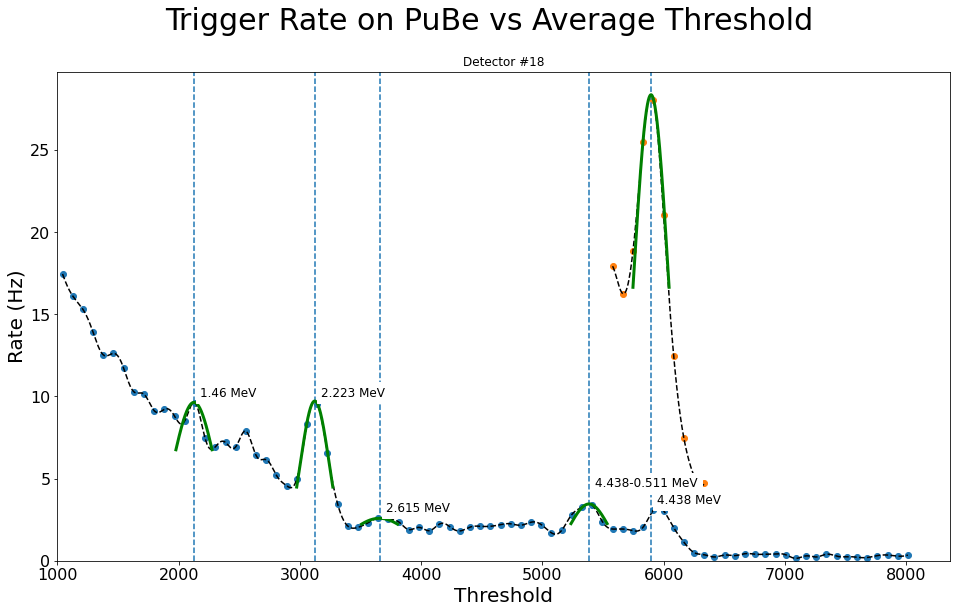

In [23]:
detnum = 18

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2130
b = 3115
c = 3690
d = 5390
e = 5900

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - e) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,10,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,10,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,4.5,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,3.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==e],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - e) < 150],gauss_params,x=fine_u[abs(fine_u - e) < 150])
plt.plot(fine_u[abs(fine_u - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Save Info
bins18 = [a,b,c,d,e]
energies18 = [1460,2238,2600,4438-511,4438]
uncertainties18 = [a_s,b_s,c_s,d_s,e_s]

plt.show()

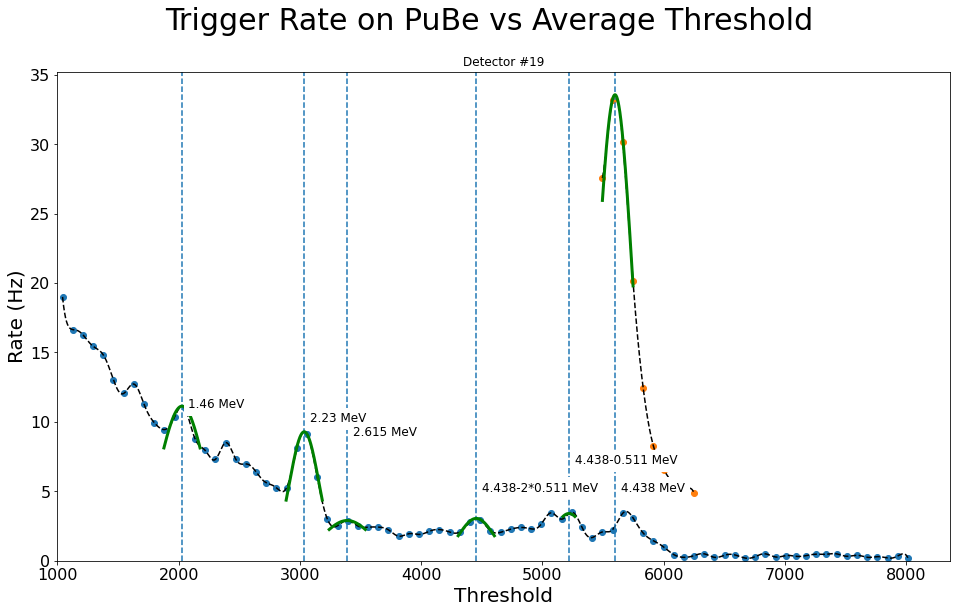

In [24]:
detnum = 19

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2054
b = 3059
c = 3395
d = 4452
e = 5169
f = 5600

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]
f = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - f) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,11,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,10,"2.23 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,9,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,5,"4.438-2*0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,7,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 50],gauss_params,x=fine[abs(fine - e) < 50])
plt.plot(fine[abs(fine - e) < 50],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Point F
plt.axvline(f,linestyle='--')
plt.text(f+50,5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=f,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==f],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - f) < 150],gauss_params,x=fine_u[abs(fine_u - f) < 150])
plt.plot(fine_u[abs(fine_u - f) < 150],fit.best_fit,color='green',linewidth=3)
f_s = fit.best_values['s']

#Save Info
bins19 = [a,b,c,d,e,f]
energies19 = [1460,2223,2600,4438-2*511,4438-511,4438]
uncertainties19 = [a_s,b_s,c_s,d_s,e_s,f_s]

plt.show()

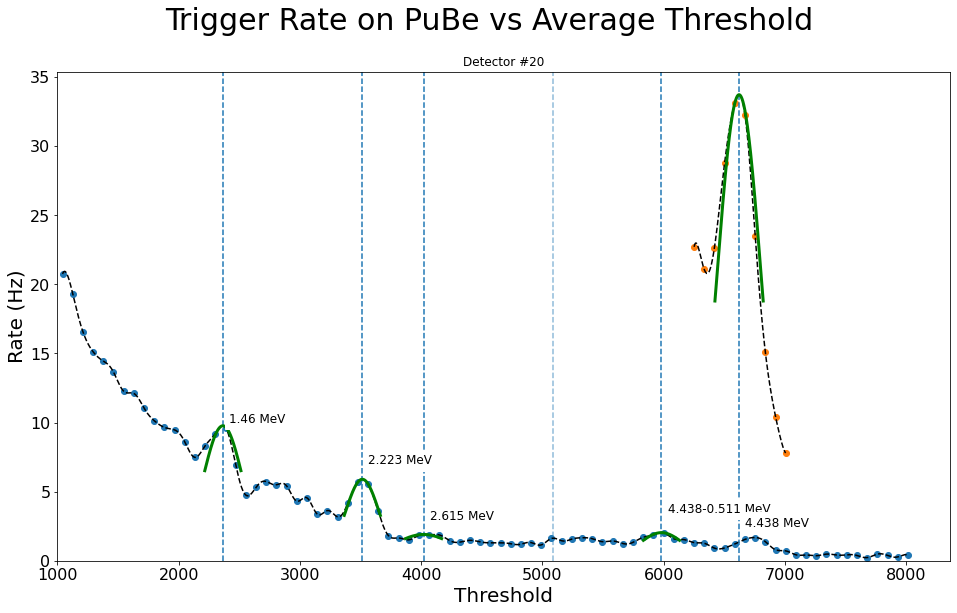

In [25]:
detnum = 20

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2400
b = 3510
c = 4063
d = 5080
e = 6005
f = 6600

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]
f = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - f) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,10,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,7,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,3,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--',alpha=0.5)

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,3.5,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine[abs(fine - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Point F
plt.axvline(f,linestyle='--')
plt.text(f+50,2.5,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=f,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==f],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - f) < 200],gauss_params,x=fine_u[abs(fine_u - f) < 200])
plt.plot(fine_u[abs(fine_u - f) < 200],fit.best_fit,color='green',linewidth=3)
f_s = fit.best_values['s']

#Save Info
bins20 = [a,b,c,e,f]
energies20 = [1460,2223,2600,4438-511,4438]
uncertainties20 = [a_s,b_s,c_s,e_s,f_s]

plt.show()

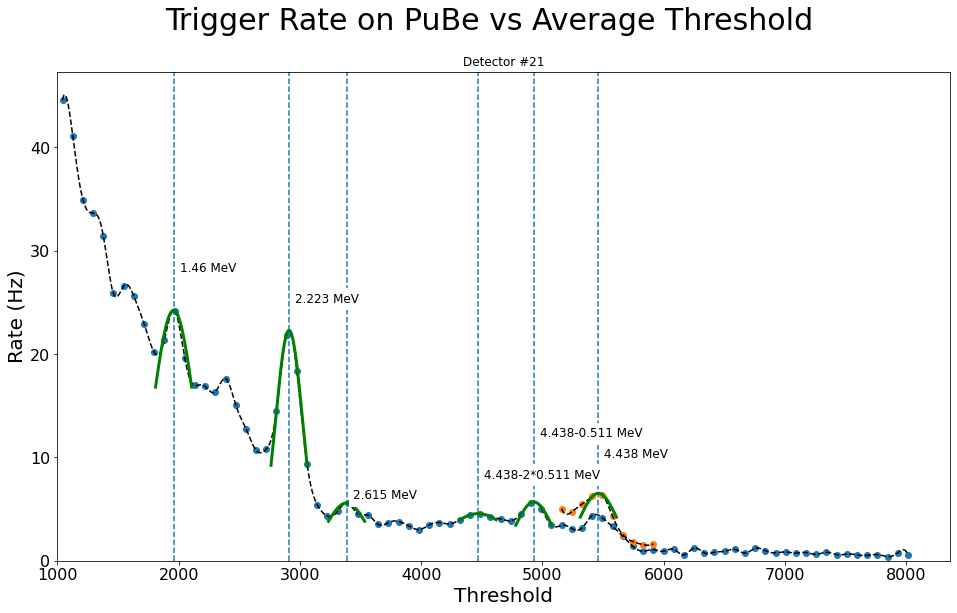

In [26]:
detnum = 21

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 1974
b = 2897 
c = 3401
d = 4496
e = 4905
f = 5445

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]
f = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - f) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,28,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,25,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,6,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,8,"4.438-2*0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,12,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine[abs(fine - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Point F
plt.axvline(f,linestyle='--')
plt.text(f+50,10,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=f,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==f],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - f) < 150],gauss_params,x=fine_u[abs(fine_u - f) < 150])
plt.plot(fine_u[abs(fine_u - f) < 150],fit.best_fit,color='green',linewidth=3)
f_s = fit.best_values['s']

#Save Info
bins21 = [a,b,c,d,e,f]
energies21 = [1460,2223,2600,4438-2*511,4438-511,4438]
uncertainties21 = [a_s,b_s,c_s,d_s,e_s,f_s]

plt.show()

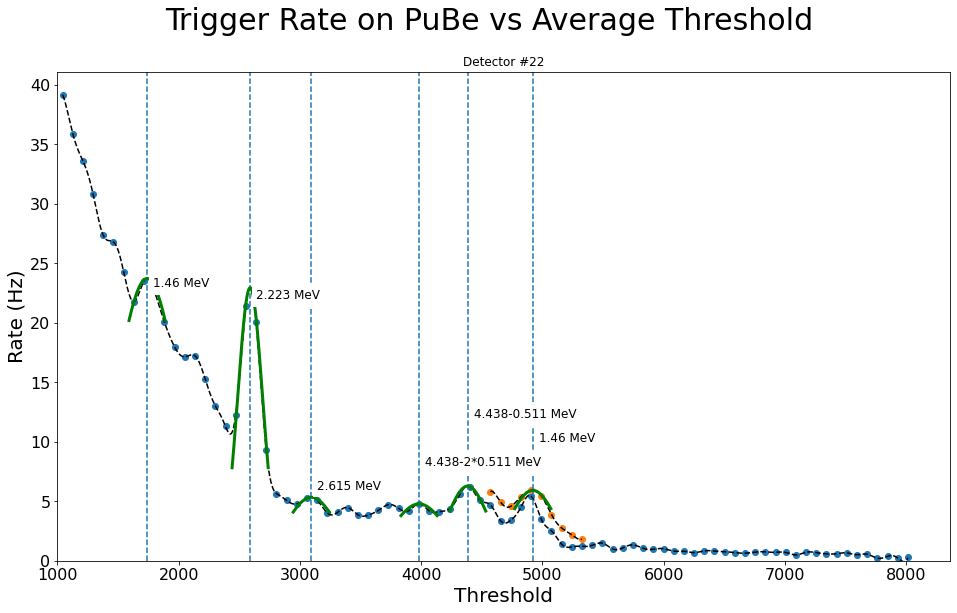

In [27]:
detnum = 22

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 1750
b = 2600
c = 3108
d = 3986
e = 4405
f = 4909

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]
f = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - f) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,23,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,22,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,6,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 150],gauss_params,x=fine[abs(fine - c) < 150])
plt.plot(fine[abs(fine - c) < 150],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,8,"4.438-2*0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,12,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine[abs(fine - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Point F
plt.axvline(f,linestyle='--')
plt.text(f+50,10,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=f,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==f],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - f) < 150],gauss_params,x=fine_u[abs(fine_u - f) < 150])
plt.plot(fine_u[abs(fine_u - f) < 150],fit.best_fit,color='green',linewidth=3)
f_s = fit.best_values['s']

bins22 = [a,b,c,d,e,f]
energies22 = [1460,2223,2600,4438-2*511,4438-511,4438]
uncertainties22 = [a_s,b_s,c_s,d_s,e_s,f_s]

plt.show()

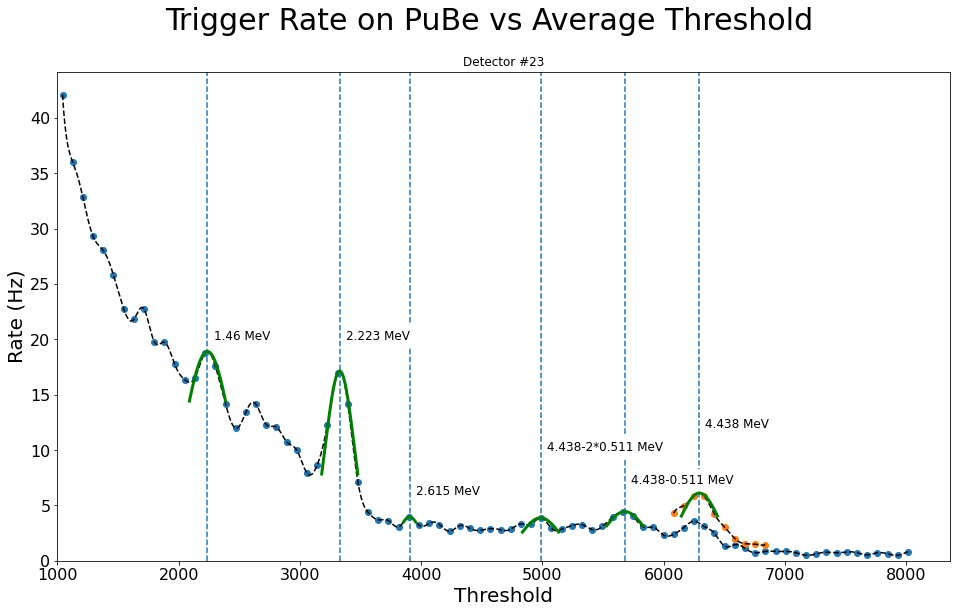

In [28]:
detnum = 23

fine_u = np.arange(min(thresh_u[detnum]),max(thresh_u[detnum]))

plt.figure(figsize=(16,9))

interpolated = interp(thresh,ranges[detnum],k=5)
interpolatey = interpolated(fine)
interpolated_u = interp(thresh_u[detnum],ranges_u[detnum],k=5)
interpolatey_u = interpolated_u(fine_u)

plt.scatter(thresh,ranges[detnum],label='det{:02d}'.format(detnum),marker='o')
plt.scatter(thresh_u[detnum],ranges_u[detnum])
plt.plot(fine,interpolatey,linestyle='--',color='k')
plt.plot(fine_u,interpolatey_u,linestyle='--',color='k')

plt.xlabel("Threshold",size=20)
plt.ylabel("Rate (Hz)",size=20)
plt.suptitle("Trigger Rate on PuBe vs Average Threshold",size=30)
plt.title("Detector #{:02d}".format(detnum))
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels

plt.xlim(1000)
plt.ylim(0)

a = 2220
b = 3317
c = 3900
d = 4999
e = 5675
f = 6250

a = fine[interpolatey == max(interpolatey[abs(fine - a) < 50])][0]
b = fine[interpolatey == max(interpolatey[abs(fine - b) < 50])][0]
c = fine[interpolatey == max(interpolatey[abs(fine - c) < 50])][0]
d = fine[interpolatey == max(interpolatey[abs(fine - d) < 50])][0]
e = fine[interpolatey == max(interpolatey[abs(fine - e) < 50])][0]
f = fine_u[interpolatey_u == max(interpolatey_u[abs(fine_u - f) < 50])][0]

#Point A
plt.axvline(a,linestyle='--')
plt.text(a+50,20,"1.46 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=a,vary=False)
gauss_params.add('a',value=interpolatey[fine==a],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - a) < 150],gauss_params,x=fine[abs(fine - a) < 150])
plt.plot(fine[abs(fine - a) < 150],fit.best_fit,color='green',linewidth=3)
a_s = fit.best_values['s']

#Point B
plt.axvline(b,linestyle='--')
plt.text(b+50,20,"2.223 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=b,vary=False)
gauss_params.add('a',value=interpolatey[fine==b],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - b) < 150],gauss_params,x=fine[abs(fine - b) < 150])
plt.plot(fine[abs(fine - b) < 150],fit.best_fit,color='green',linewidth=3)
b_s = fit.best_values['s']

#Point C
plt.axvline(c,linestyle='--')
plt.text(c+50,6,"2.615 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=c,vary=False)
gauss_params.add('a',value=interpolatey[fine==c],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - c) < 50],gauss_params,x=fine[abs(fine - c) < 50])
plt.plot(fine[abs(fine - c) < 50],fit.best_fit,color='green',linewidth=3)
c_s = fit.best_values['s']

#Point D
plt.axvline(d,linestyle='--')
plt.text(d+50,10,"4.438-2*0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=d,vary=False)
gauss_params.add('a',value=interpolatey[fine==d],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - d) < 150],gauss_params,x=fine[abs(fine - d) < 150])
plt.plot(fine[abs(fine - d) < 150],fit.best_fit,color='green',linewidth=3)
d_s = fit.best_values['s']

#Point E
plt.axvline(e,linestyle='--')
plt.text(e+50,7,"4.438-0.511 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=e,vary=False)
gauss_params.add('a',value=interpolatey[fine==e],vary=False)
fit = gauss_mod.fit(interpolatey[abs(fine - e) < 150],gauss_params,x=fine[abs(fine - e) < 150])
plt.plot(fine[abs(fine - e) < 150],fit.best_fit,color='green',linewidth=3)
e_s = fit.best_values['s']

#Point F
plt.axvline(f,linestyle='--')
plt.text(f+50,12,"4.438 MeV",fontsize=12,backgroundcolor='white')
gauss_params.add('m',value=f,vary=False)
gauss_params.add('a',value=interpolatey_u[fine_u==f],vary=False)
fit = gauss_mod.fit(interpolatey_u[abs(fine_u - f) < 150],gauss_params,x=fine_u[abs(fine_u - f) < 150])
plt.plot(fine_u[abs(fine_u - f) < 150],fit.best_fit,color='green',linewidth=3)
f_s = fit.best_values['s']

bins23 = [a,b,c,d,e,f]
energies23 = [1460,2223,2600,4438-2*511,4438-511,4438]
uncertainties23 = [a_s,b_s,c_s,d_s,e_s,f_s]

plt.show()

## Fitting the calibration lines

In [29]:
#But first, some cleanup and organizing
try:
    bins = [[],bins01,bins02,bins03,bins04,bins05,bins06,bins07,bins08,bins09,
            bins10,bins11,bins12,bins13,bins14,bins15,bins16,bins17,bins18,
            bins19,bins20,bins21,bins22,bins23]
    energies = [[],energies01,energies02,energies03,energies04,energies05,energies06,
                energies07,energies08,energies09,energies10,energies11,energies12,
                energies13,energies14,energies15,energies16,energies17,energies18,
                energies19,energies20,energies21,energies22,energies23]
    uncertainties = [[],uncertainties01,uncertainties02,uncertainties03,uncertainties04,uncertainties05,uncertainties06,
               uncertainties07,uncertainties08,uncertainties09,uncertainties10,uncertainties11,uncertainties12,
               uncertainties13,uncertainties14,uncertainties15,uncertainties16,uncertainties17,uncertainties18,
               uncertainties19,uncertainties20,uncertainties21,uncertainties22,uncertainties23]
    del a,b,c,d,e,f,interpolated,interpolatey,interpolated_u,interpolatey_u,fine_u
    del bins01,bins02,bins03,bins04,bins05,bins06,bins07,bins08,bins09,bins10,bins11,bins12,bins13,bins14,bins15,bins16,bins17,bins18,bins19,bins20,bins21,bins22,bins23
    del energies01,energies02,energies03,energies04,energies05,energies06,energies07,energies08,energies09,energies10,energies11,energies12,energies13,energies14,energies15
    del energies16,energies17,energies18,energies19,energies20,energies21,energies22,energies23
    del uncertainties01,uncertainties02,uncertainties03,uncertainties04,uncertainties05,uncertainties06,uncertainties07,uncertainties08,uncertainties09,uncertainties10,uncertainties11,uncertainties12,uncertainties13,uncertainties14,uncertainties15,uncertainties16,
    del uncertainties17,uncertainties18,uncertainties19,uncertainties20,uncertainties21,uncertainties22,uncertainties23
except:
    print("bins, energies, uncertainties already present at lengths ",len(bins),", ",len(energies),", ",len(uncertainties)," respectively.")
    try:
        del params_quad,params_lin #allow overwrite to remove pieces
    except:
        pass

def linear(x,m,b):
    return m*x + b
def linear_inverse(x,m,b):
    return (x - b)/m
def quadratic(x,a,b,c):
    return a*x**2 + b*x + c
def quadratic_inverse(x,a,b,c):
    return (-b + np.sqrt(b**2 - 4*a*c + 4*a*x))/(2*a)

lin_mod = lf.Model(linear)
quad_mod = lf.Model(quadratic)
params_lin = lin_mod.make_params(m=1,b=0)
#params_lin.add('m',min=0)
#params_lin.add('b',min=0)
params_quad = quad_mod.make_params(a=0,b=1,c=0)
#params_quad.add('a',min=0,max=10)
#params_quad.add('b',min=0,max=10)
#params_quad.add('c',min=-50,max=500)

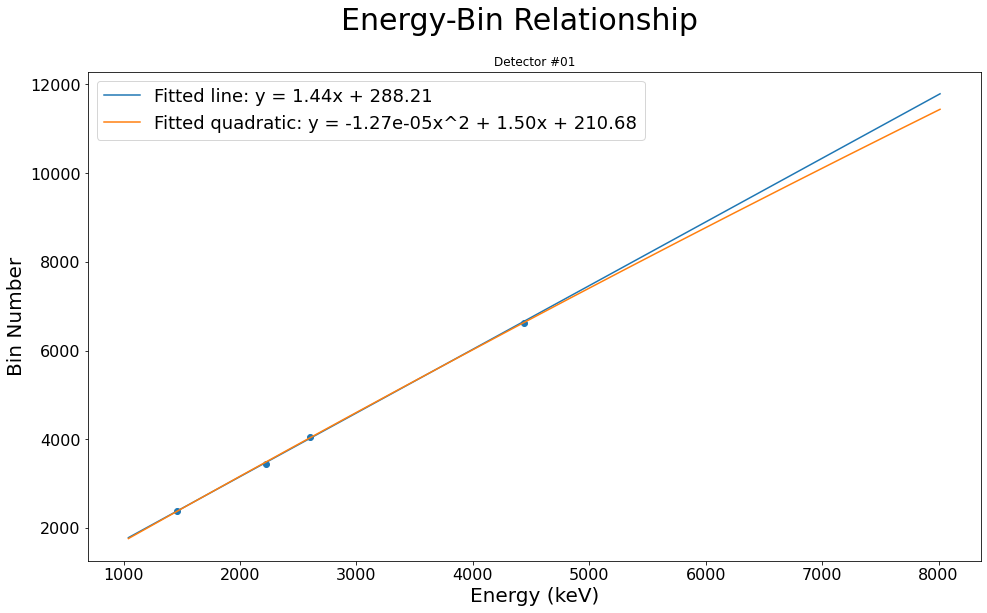

In [30]:
detnum = 1

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

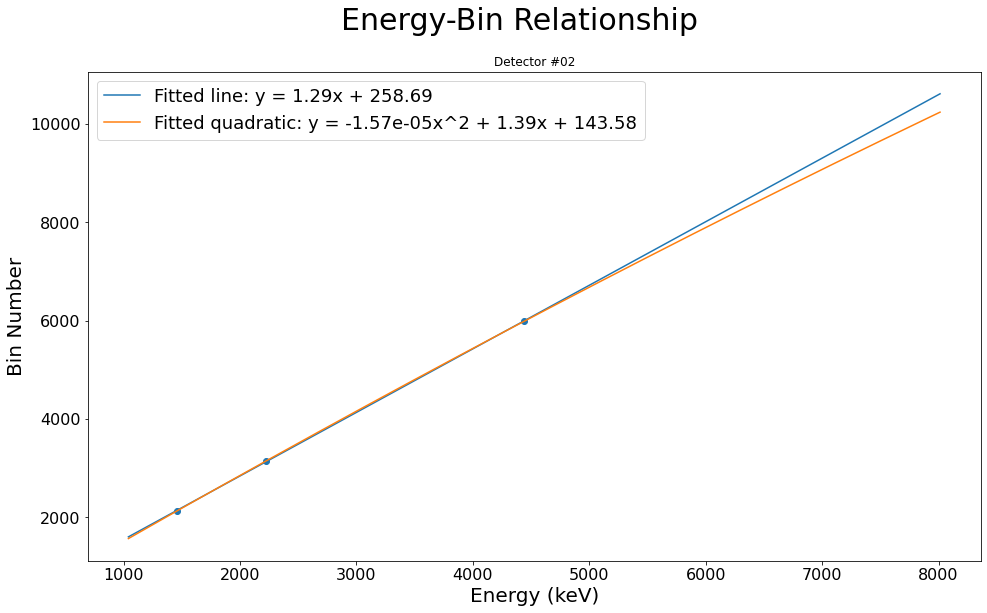

In [31]:
detnum = 2

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

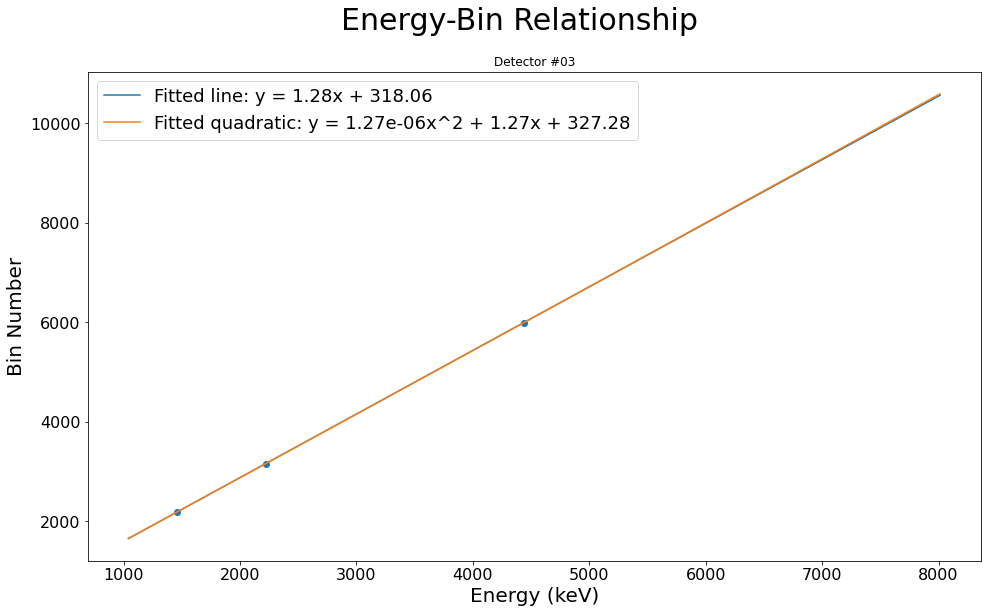

In [32]:
detnum = 3

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])


plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

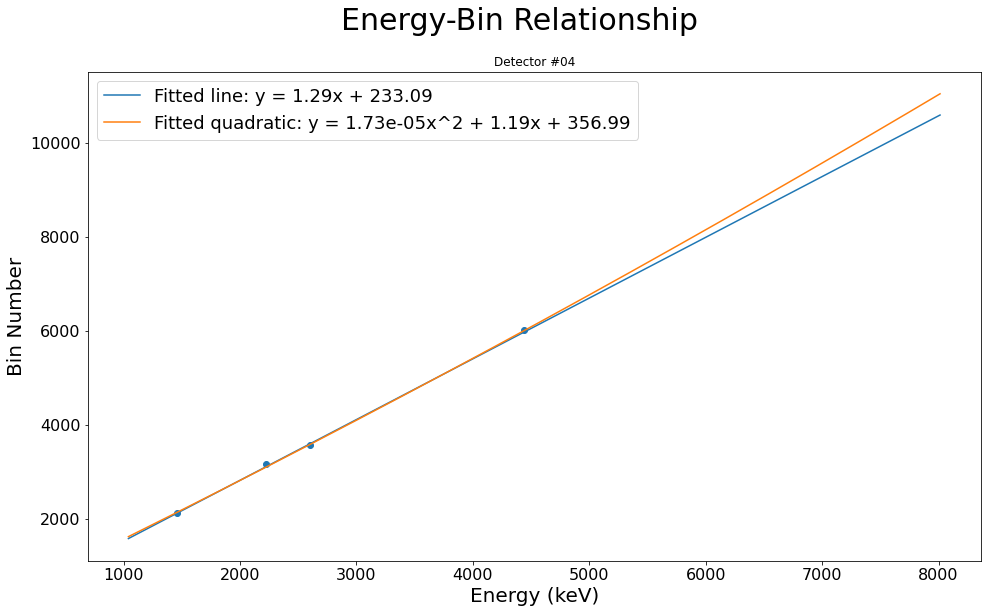

In [33]:
detnum = 4

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [34]:
quad_fit

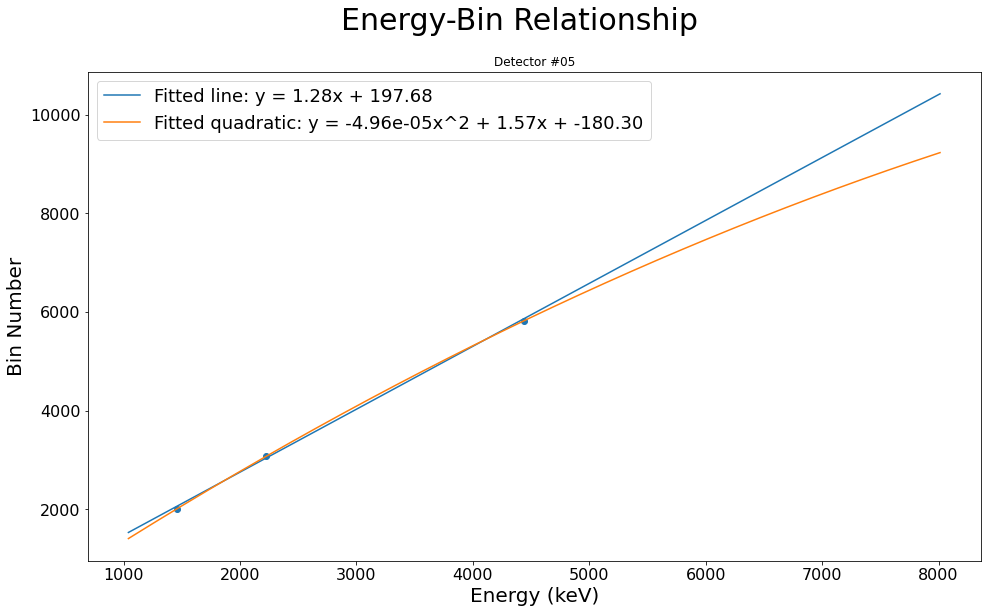

In [35]:
detnum = 5

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

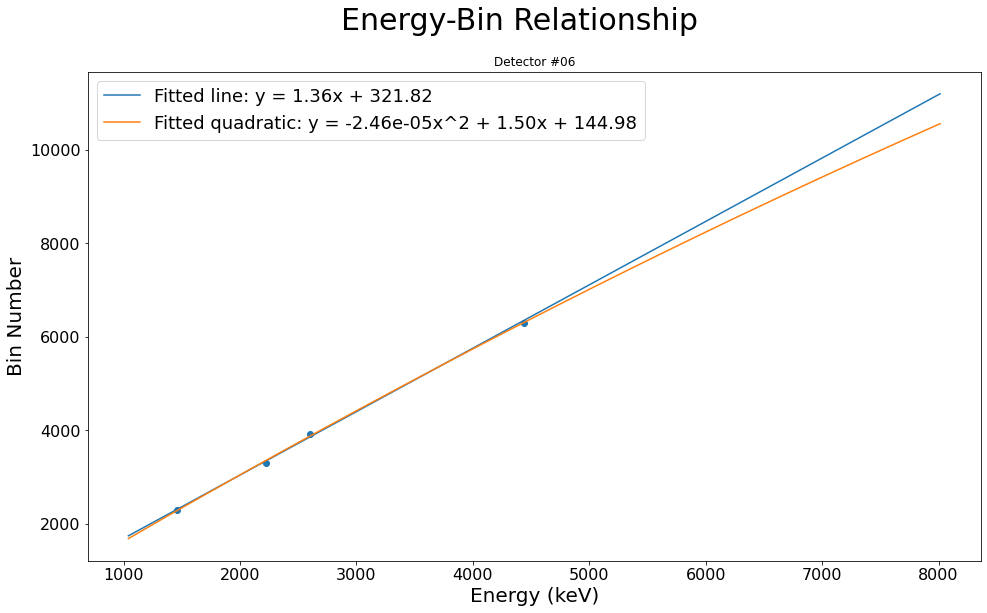

In [36]:
detnum = 6

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [37]:
quad_fit

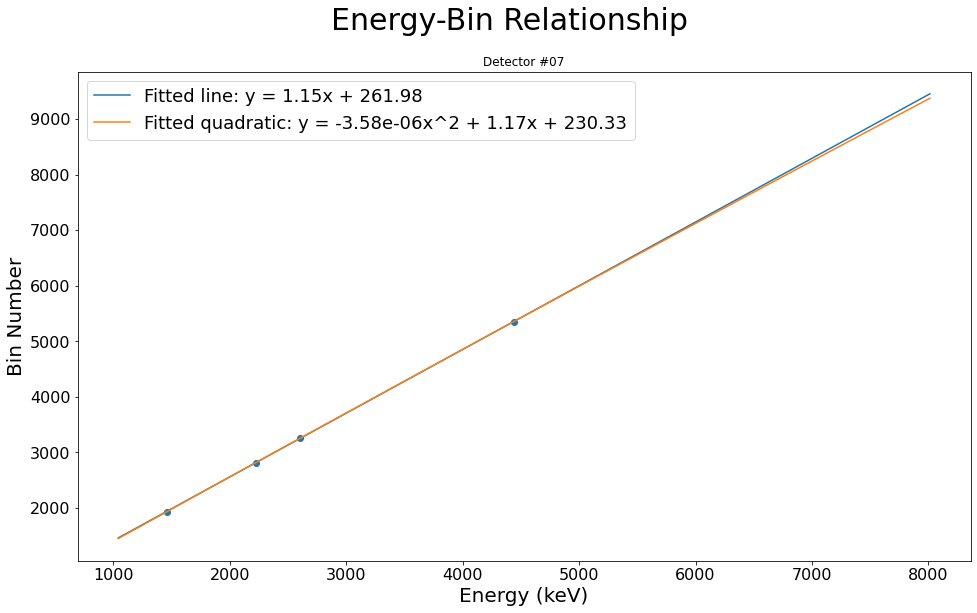

In [38]:
detnum = 7

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [39]:
quad_fit

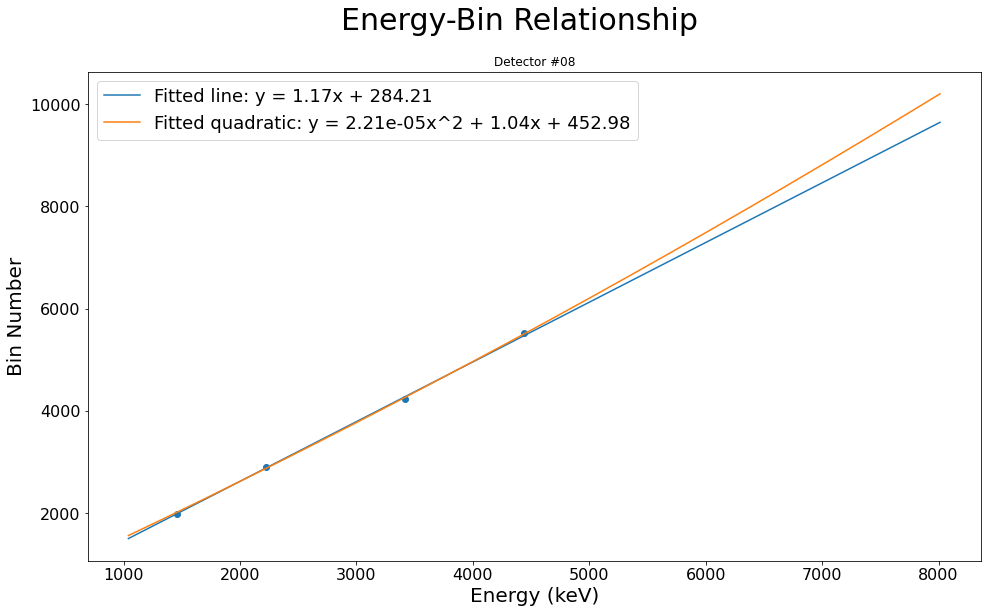

In [40]:
detnum = 8

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [41]:
quad_fit

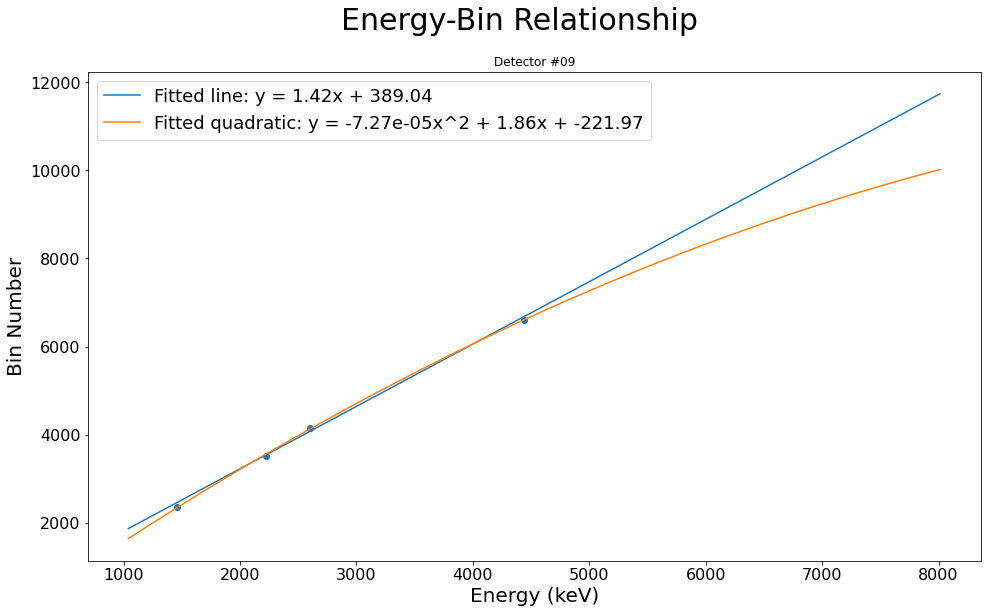

In [42]:
detnum = 9

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [43]:
quad_fit

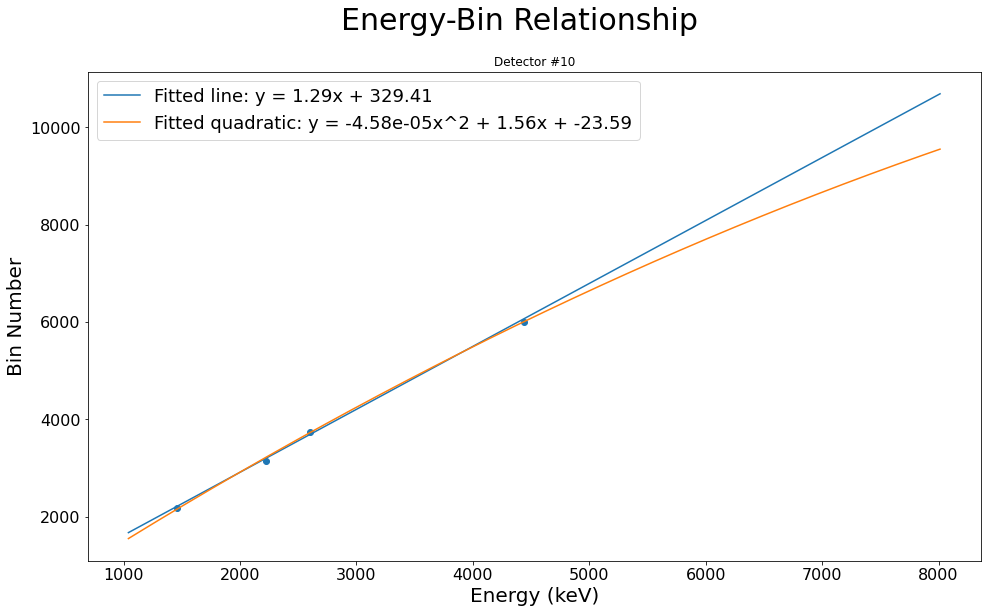

In [44]:
detnum = 10

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [45]:
quad_fit

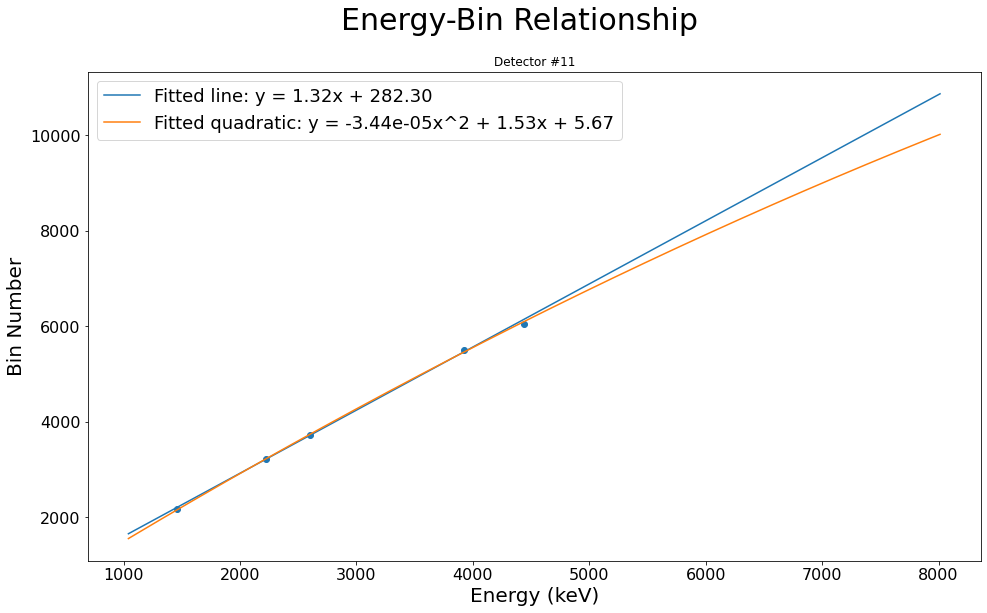

In [46]:
detnum = 11

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [47]:
quad_fit

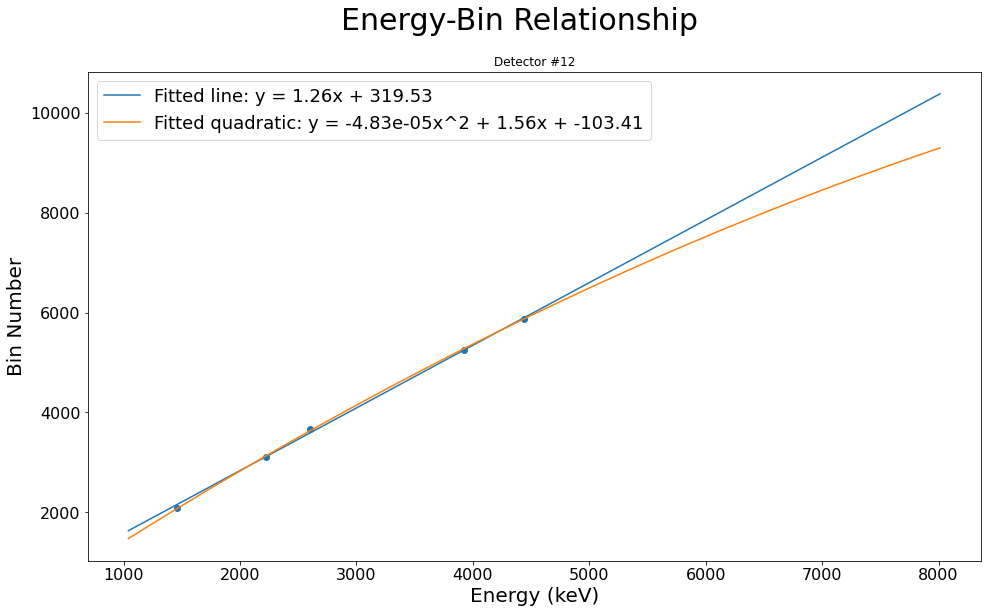

In [48]:
detnum = 12

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [49]:
quad_fit

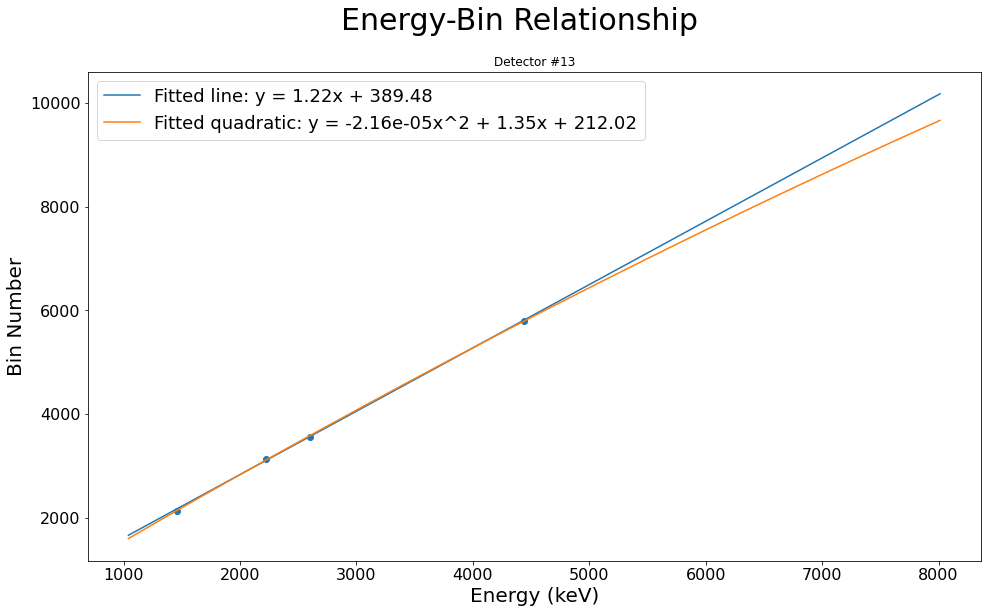

In [50]:
detnum = 13

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [51]:
quad_fit

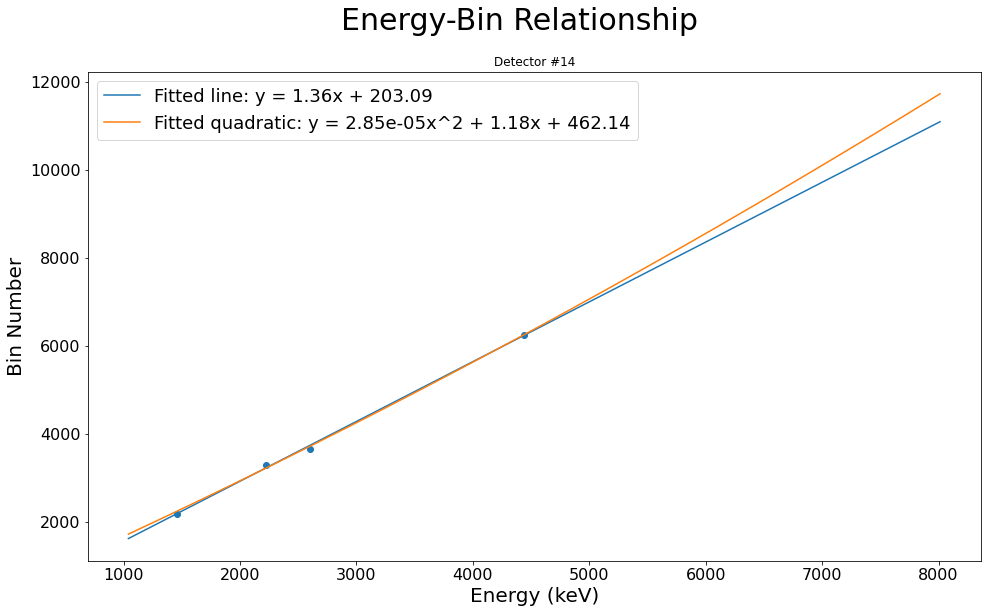

In [52]:
detnum = 14

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [53]:
quad_fit

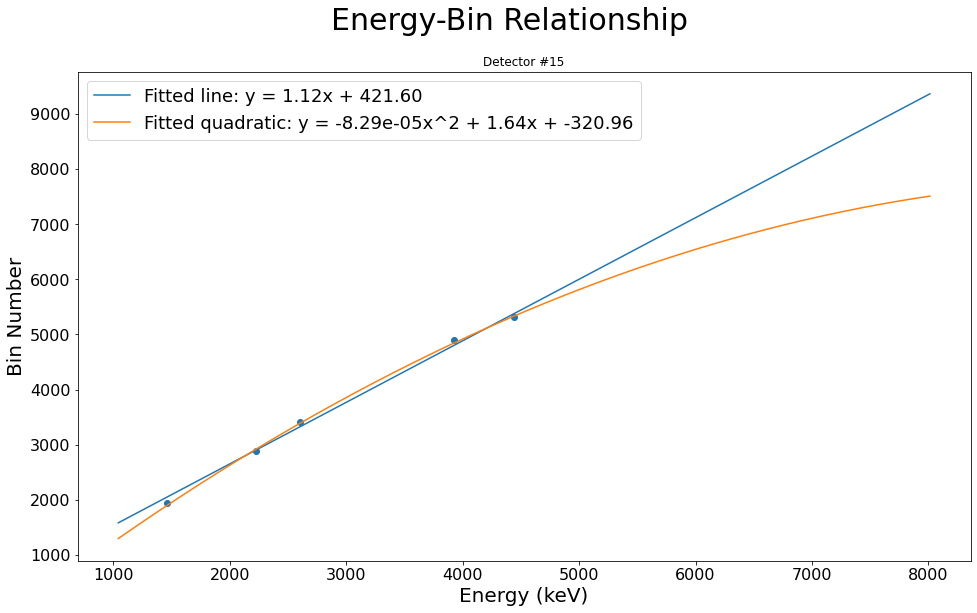

In [54]:
detnum = 15

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [55]:
quad_fit

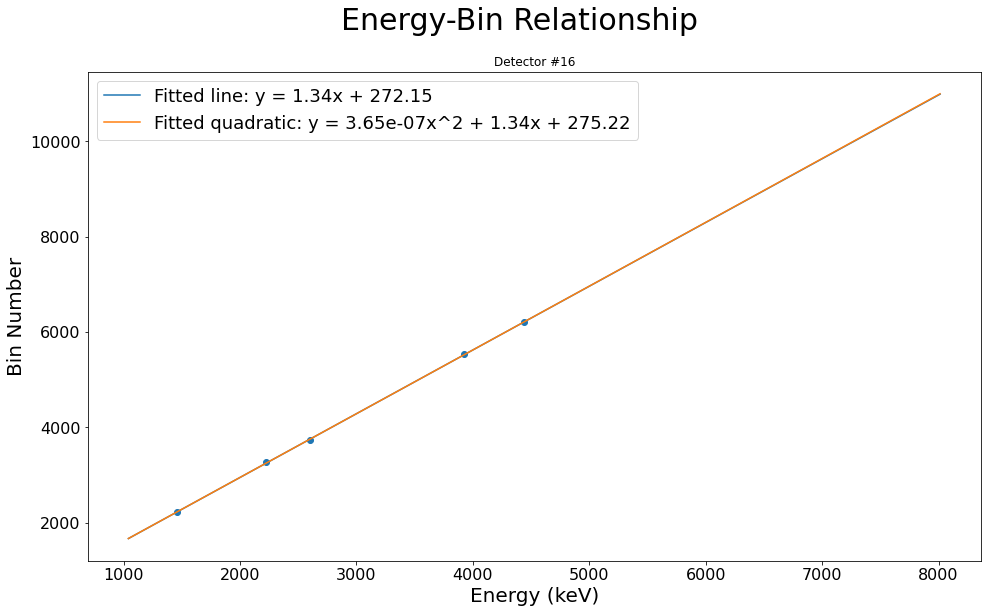

In [56]:
detnum = 16

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [57]:
quad_fit

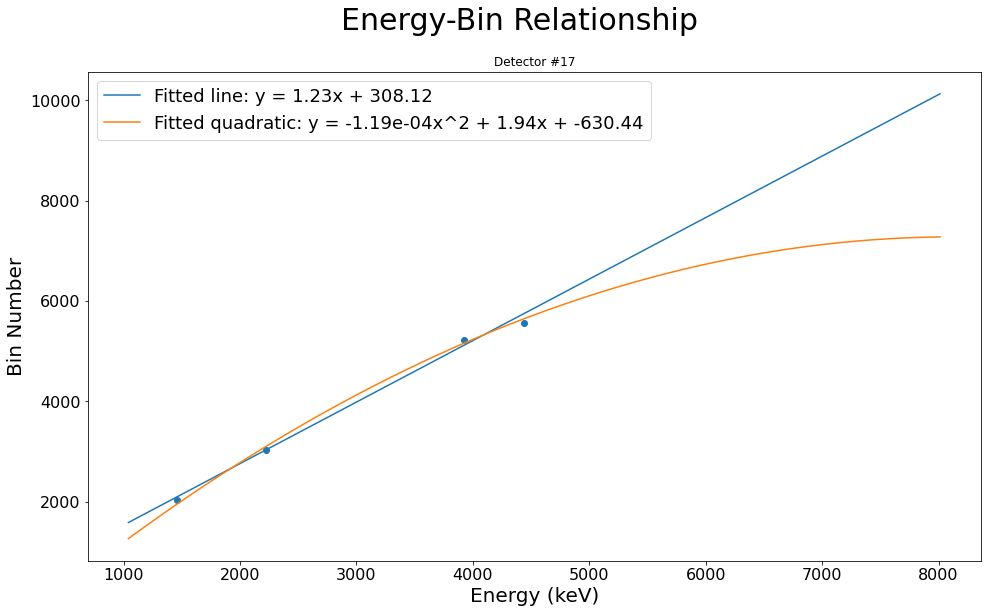

In [58]:
detnum = 17

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [59]:
quad_fit

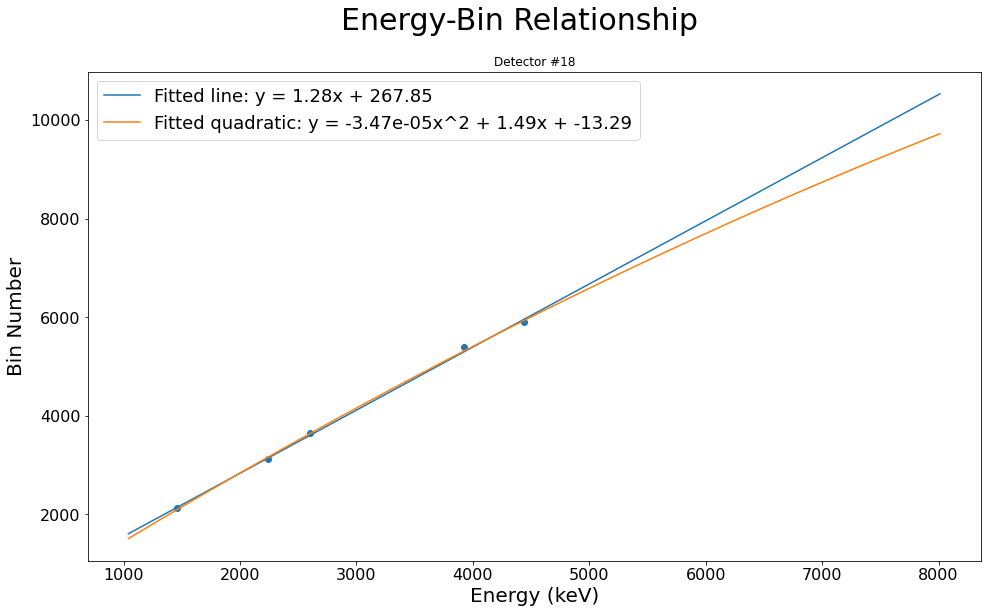

In [60]:
detnum = 18

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [61]:
quad_fit

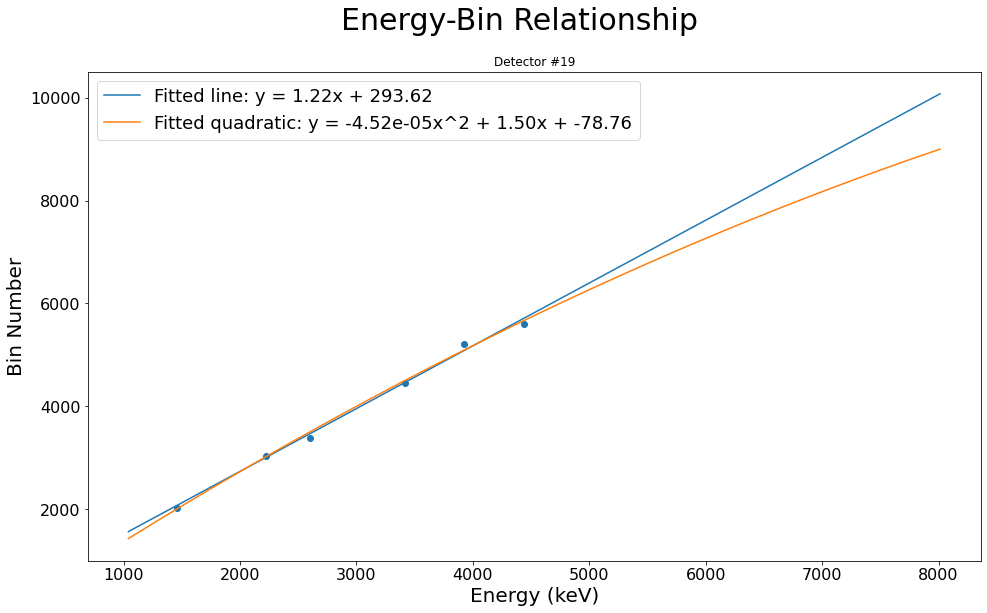

In [62]:
detnum = 19

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [63]:
quad_fit

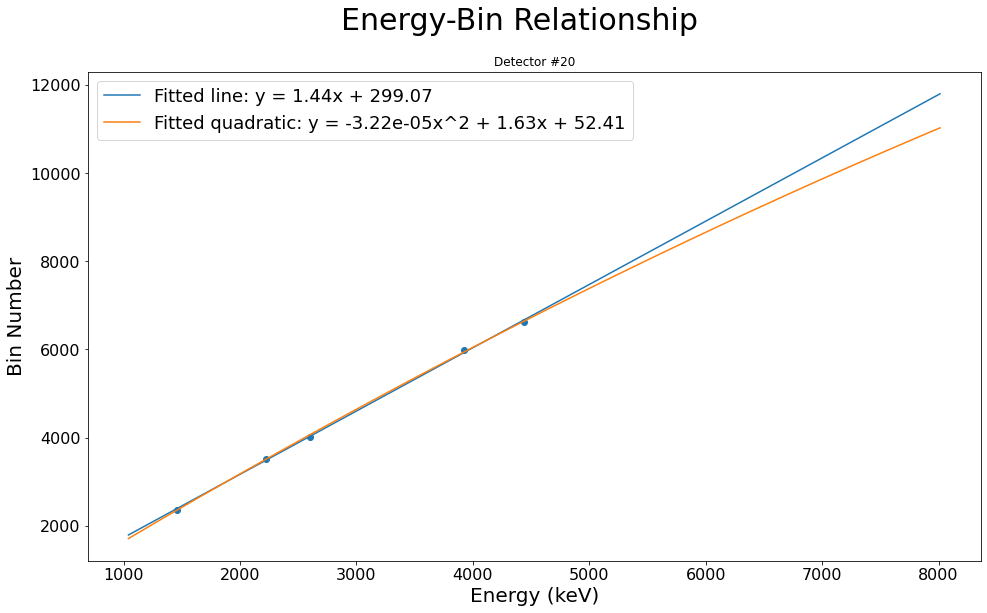

In [64]:
detnum = 20

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [65]:
quad_fit

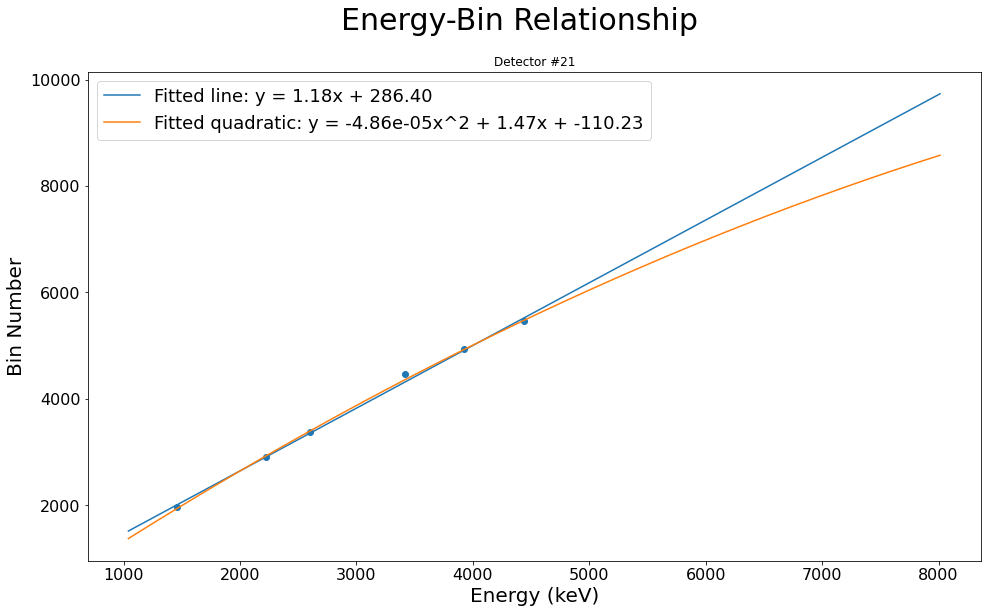

In [66]:
detnum = 21

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [67]:
quad_fit

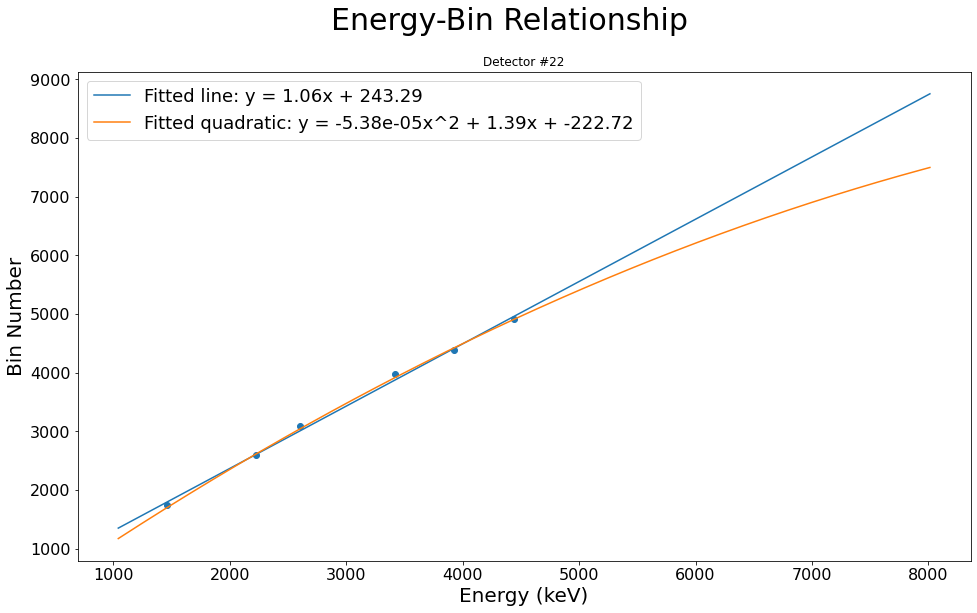

In [68]:
detnum = 22

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [69]:
quad_fit

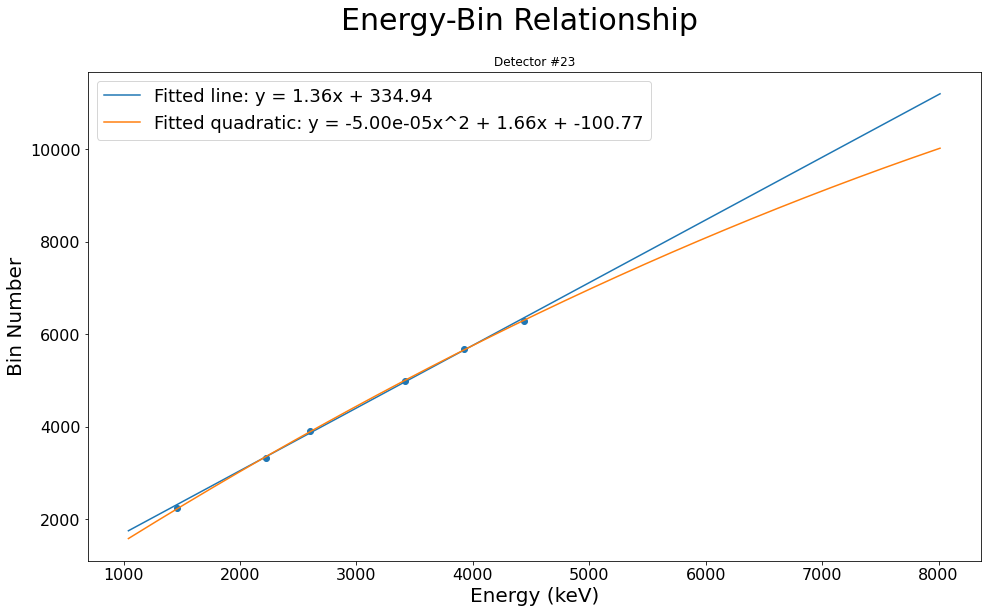

In [70]:
detnum = 23

plt.figure(figsize=(16,9))

lin_fit = lin_mod.fit(bins[detnum],params_lin,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
lin_dict = lin_fit.best_values
lin_curve = linear(fine,lin_dict['m'],lin_dict['b'])
quad_fit = quad_mod.fit(bins[detnum],params_quad,x=energies[detnum],weights=[1/x for x in uncertainties[detnum]])
quad_dict = quad_fit.best_values
quad_curve = quadratic(fine,quad_dict['a'],quad_dict['b'],quad_dict['c'])

plt.scatter(energies[detnum],bins[detnum])
plt.plot(fine,lin_curve,label="Fitted line: y = {:.2f}x + {:.2f}".format(lin_dict['m'],lin_dict['b']))
plt.plot(fine,quad_curve,label="Fitted quadratic: y = {:.2e}x^2 + {:.2f}x + {:.2f}".format(quad_dict['a'],quad_dict['b'],quad_dict['c']))
plt.suptitle("Energy-Bin Relationship",fontsize=30)
plt.title("Detector #{:02d}".format(detnum))
plt.xlabel("Energy (keV)",fontsize=20)
plt.ylabel("Bin Number",fontsize=20)

plt.legend(fontsize=18)
plt.show()

lin_fit
#quad_fit

In [71]:
quad_fit